In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2020-2021_GOOD.csv
/kaggle/input/2019-2020_GOOD.csv
/kaggle/input/2022-2023_GOOD.csv
/kaggle/input/2018-2019_GOOD.csv
/kaggle/input/2021-2022_GOOD.csv
/kaggle/input/2023-2024_GOOD.csv


LOADING THE NEEDED PACKAGES

In [3]:
!pip install torch
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

import optuna
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from collections import Counter

import xgboost
from xgboost import XGBClassifier

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna.visualization.matplotlib as optuna_vis


**LOADING IN THE DATA**



In [5]:
data_dir = '/kaggle/input/'

print(os.listdir(data_dir))


training2018 = os.path.join(data_dir, '2018-2019_GOOD.csv')
training2019 = os.path.join(data_dir, '2019-2020_GOOD.csv')
training2020 = os.path.join(data_dir, '2020-2021_GOOD.csv')
training2021 = os.path.join(data_dir, '2021-2022_GOOD.csv')
training2022 = os.path.join(data_dir, '2022-2023_GOOD.csv')
testset = os.path.join(data_dir, '2023-2024_GOOD.csv')


df_2018 = pd.read_csv(training2018, sep=';')
df_2019 = pd.read_csv(training2019, sep=';')
df_2020 = pd.read_csv(training2020, sep=';')
df_2021 = pd.read_csv(training2021, sep=';')
df_2022 = pd.read_csv(training2022, sep=';')
df_Tes = pd.read_csv(testset, sep=';')

['2020-2021_GOOD.csv', '2019-2020_GOOD.csv', '2022-2023_GOOD.csv', '2018-2019_GOOD.csv', '2021-2022_GOOD.csv', '2023-2024_GOOD.csv']


**PREPROCESSING - FEATURE TRANSFORMATION**


In [6]:
def process_dataframe(df):
    # Convert 'Date' to datetime and get the day of the week
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df['Day_of_Week'] = df['Date'].dt.strftime('%A')
    
    # Categorize 'Day_of_Week' to make it a categorical variable
    df['Day_of_Week'] = pd.Categorical(df['Day_of_Week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

    # Convert 'Time' to proper time format without seconds
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.time

    # Function to categorize time into parts of the day
    def categorize_time(time):
        if pd.isnull(time):
            return 'Unknown'
        elif time >= pd.to_datetime('12:00').time() and time < pd.to_datetime('15:00').time():
            return 'Early Afternoon'
        elif time >= pd.to_datetime('15:00').time() and time < pd.to_datetime('18:00').time():
            return 'Late Afternoon'
        elif time >= pd.to_datetime('18:00').time() and time <= pd.to_datetime('23:59').time():
            return 'Evening'
        else:
            return 'Morning'
    
    # Apply the time categorization function
    df['Time_Category'] = df['Time'].apply(categorize_time)
    
    def assign_points(ftr):
        if ftr == 'H':  # Home team won
            return pd.Series({'HPG': 3, 'APG': 0})
        elif ftr == 'A':  # Away team won
            return pd.Series({'HPG': 0, 'APG': 3})
        elif ftr == 'D':  # Draw
            return pd.Series({'HPG': 1, 'APG': 1})
        else:
            return pd.Series({'HPG': None, 'APG': None})  # Voor missende waarden

    
    df[['HFPG', 'AFPG']] = df['FTR'].apply(assign_points)
    df[['HHPG', 'AHPG']] = df['HTR'].apply(assign_points)
    
    return df


dfs = [df_2018, df_2019, df_2020, df_2021, df_2022, df_Tes]

for i in range(len(dfs)):
    dfs[i] = process_dataframe(dfs[i])

df_2018, df_2019, df_2020, df_2021, df_2022, df_Tes = dfs


In [7]:
def calculate_previous_match_stats(df, features_home, features_away, window=5):
    df = df.copy()
    df.sort_values(by='Date', inplace=True)  # Sorteer op datum
    teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()  # Unieke teams vinden

    for feature_home, feature_away in zip(features_home, features_away):
        df[f'{feature_home}_HomeAvg'] = np.nan
        df[f'{feature_away}_AwayAvg'] = np.nan

    for team in teams:
        team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)].copy()
        team_matches = team_matches.sort_values(by='Date')

        for i, match in team_matches.iterrows():
            past_matches = team_matches[team_matches['Date'] < match['Date']].tail(window)

            if len(past_matches) > 0:
                for feature_home, feature_away in zip(features_home, features_away):
                    if match['HomeTeam'] == team:
                        feature_values = pd.concat([
                            past_matches.loc[past_matches['HomeTeam'] == team, feature_home],
                            past_matches.loc[past_matches['AwayTeam'] == team, feature_away]
                        ])
                        home_avg = feature_values.mean()
                        df.loc[i, f'{feature_home}_HomeAvg'] = round(home_avg, 2)  # Afronden op 2 decimalen

                    if match['AwayTeam'] == team:
                        feature_values = pd.concat([
                            past_matches.loc[past_matches['HomeTeam'] == team, feature_home],
                            past_matches.loc[past_matches['AwayTeam'] == team, feature_away]
                        ])
                        away_avg = feature_values.mean()
                        df.loc[i, f'{feature_away}_AwayAvg'] = round(away_avg, 2)  # Afronden op 2 decimalen
            else:
                for feature_home, feature_away in zip(features_home, features_away):
                    df.loc[i, f'{feature_home}_HomeAvg'] = np.nan
                    df.loc[i, f'{feature_away}_AwayAvg'] = np.nan
                    
    all_features = features_home + features_away
    df = df.drop(columns=all_features, errors='ignore')

    return df

features_HOME = ['HS', 'HST', 'HF', 'HC', 'HY', 'HR', 'FTHG', 'HTHG', 'HFPG', 'HHPG']  # Thuisteam statistieken
features_AWAY = ['AS', 'AST', 'AF', 'AC', 'AY', 'AR', 'FTAG', 'HTAG', 'AFPG', 'AHPG']  # Uitteam statistieken

df_2018 = calculate_previous_match_stats(df_2018, features_HOME, features_AWAY, window=5)
df_2019 = calculate_previous_match_stats(df_2019, features_HOME, features_AWAY, window=5)
df_2020 = calculate_previous_match_stats(df_2020, features_HOME, features_AWAY, window=5)
df_2021 = calculate_previous_match_stats(df_2021, features_HOME, features_AWAY, window=5)
df_2022 = calculate_previous_match_stats(df_2022, features_HOME, features_AWAY, window=5)
df_Tes = calculate_previous_match_stats(df_Tes, features_HOME, features_AWAY, window=5)

In [8]:
features_HOME_AVG = ['HS_HomeAvg', 'HST_HomeAvg', 'HF_HomeAvg', 'HC_HomeAvg', 'HY_HomeAvg', 'HR_HomeAvg', 'FTHG_HomeAvg', 'HTHG_HomeAvg', 'HFPG_HomeAvg', 'HHPG_HomeAvg', 'FRHDEF', 'FRHMID', 'FRHATT', 'FRHAVG']
features_AWAY_AVG = ['AS_AwayAvg', 'AST_AwayAvg', 'AF_AwayAvg', 'AC_AwayAvg', 'AY_AwayAvg', 'AR_AwayAvg', 'FTAG_AwayAvg', 'HTAG_AwayAvg', 'AFPG_AwayAvg', 'AHPG_AwayAvg', 'FRADEF', 'FRAMID', 'FRAATT', 'FRAAVG']

features_Home_Processed = ['S', 'ST', 'F', 'C', 'Y', 'R', 'FTG', 'HTG', 'FPG', 'HPG', 'FRDEF', 'FRMID', 'FRATT', 'FRAVG']

def add_difference_columns(df, features_Home_Processed, features_AWAY_AVG, features_HOME_AVG):
    df = df.copy()
    
    for i in range(len(features_Home_Processed)):
        home_avg_col = features_HOME_AVG[i]
        away_avg_col = features_AWAY_AVG[i]
        diff_col = f'Diff_{features_Home_Processed[i]}'

        df[diff_col] = df[home_avg_col] - df[away_avg_col]
        
    return df

df_2018 = add_difference_columns(df_2018, features_Home_Processed, features_AWAY_AVG, features_HOME_AVG)
df_2019 = add_difference_columns(df_2019, features_Home_Processed, features_AWAY_AVG, features_HOME_AVG)
df_2020 = add_difference_columns(df_2020, features_Home_Processed, features_AWAY_AVG, features_HOME_AVG)
df_2021 = add_difference_columns(df_2021, features_Home_Processed, features_AWAY_AVG, features_HOME_AVG)
df_2022 = add_difference_columns(df_2022, features_Home_Processed, features_AWAY_AVG, features_HOME_AVG)
df_Tes = add_difference_columns(df_Tes, features_Home_Processed, features_AWAY_AVG, features_HOME_AVG)


In [9]:
final_training= pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], axis=0)

In [10]:
columns_to_drop = ['Time', 'Date', 'Div', 'HTR'] + features_HOME_AVG + features_AWAY_AVG
data = final_training.drop(columns=columns_to_drop, errors='ignore')
df_Tes = df_Tes.drop(columns=columns_to_drop, errors='ignore')

In [11]:
print(data.head())
print(df_Tes.head())

       HomeTeam        AwayTeam FTR     Referee  B365H  B365D  B365A  \
0    Man United       Leicester   H  A Marriner   1.57    3.9   7.50   
1   Bournemouth         Cardiff   H    K Friend   1.90    3.6   4.50   
2        Fulham  Crystal Palace   A      M Dean   2.50    3.4   3.00   
3  Huddersfield         Chelsea   A  C Kavanagh   6.50    4.0   1.61   
4     Newcastle       Tottenham   A  M Atkinson   3.90    3.5   2.04   

  Day_of_Week    Time_Category  Diff_S  ...  Diff_Y  Diff_R  Diff_FTG  \
0      Friday          Evening     NaN  ...     NaN     NaN       NaN   
1    Saturday   Late Afternoon     NaN  ...     NaN     NaN       NaN   
2    Saturday   Late Afternoon     NaN  ...     NaN     NaN       NaN   
3    Saturday   Late Afternoon     NaN  ...     NaN     NaN       NaN   
4    Saturday  Early Afternoon     NaN  ...     NaN     NaN       NaN   

   Diff_HTG  Diff_FPG  Diff_HPG  Diff_FRDEF  Diff_FRMID  Diff_FRATT  \
0       NaN       NaN       NaN           5           7  

**DATA PREPARATION - HANDLING MISSING VALUES**

In [12]:
total_missing_data = data.isna().sum().sum()
total_missing_df_Tes = df_Tes.isna().sum().sum()

print(f'Total missing values in df_training: {total_missing_data}')
print(f'Total missing values in df_test: {total_missing_df_Tes}')

Total missing values in df_training: 520
Total missing values in df_test: 100


In [13]:
data_cleaned = data.dropna()
df_Tes_cleaned = df_Tes.dropna()

print(data_cleaned.shape)
print(df_Tes_cleaned.shape)



(1848, 23)
(370, 23)


**DATA PREPARATION - LABEL ENCODING**

In [14]:
data_original = data_cleaned.copy()
df_test = df_Tes_cleaned.copy()

data_original['Set'] = 1
df_test['Set'] = 2        

combined_data = pd.concat([data_original, df_test], ignore_index=True)

# LABEL ENCODING
categorical_columns = combined_data.select_dtypes(include=['object']).columns.tolist()
print("Categorische kolommen:", categorical_columns)

if 'Day_of_Week' not in categorical_columns:
    categorical_columns.append('Day_of_Week')

label_encoders = {}  

for col in categorical_columns:
    if col in combined_data.columns:  
        le = LabelEncoder()
        combined_data[col] = le.fit_transform(combined_data[col])
        label_encoders[col] = le  

print(combined_data.head())


Categorische kolommen: ['HomeTeam', 'AwayTeam', 'FTR', 'Referee', 'Time_Category']
   HomeTeam  AwayTeam  FTR  Referee  B365H  B365D  B365A  Day_of_Week  \
0        26         2    0       32   2.10    3.6   3.70            2   
1        23        10    2        3   1.28    6.0  12.00            2   
2        13        27    2       20   2.04    3.5   3.90            2   
3         7         0    2       19   1.80    4.0   4.50            2   
4         6        18    1        5   3.25    3.1   2.54            2   

   Time_Category  Diff_S  ...  Diff_R  Diff_FTG  Diff_HTG  Diff_FPG  Diff_HPG  \
0              2    -7.0  ...     0.0      -2.0      -1.0      -3.0      -3.0   
1              2     0.0  ...     0.0       2.0       2.0       3.0       3.0   
2              2     2.0  ...     0.0      -1.0      -1.0      -1.0      -1.0   
3              2     4.0  ...     0.0       3.0       2.0       3.0       3.0   
4              0    -5.0  ...     0.0      -1.0      -1.0       0.0      

In [15]:
train_data = combined_data[combined_data['Set'] == 1].drop(columns=['Set'])
test_data = combined_data[combined_data['Set'] == 2].drop(columns=['Set'])

print("Train Data:")
print(train_data.head())
print(train_data.shape)
print("\nTest Data:")
print(test_data.head())

Train Data:
   HomeTeam  AwayTeam  FTR  Referee  B365H  B365D  B365A  Day_of_Week  \
0        26         2    0       32   2.10    3.6   3.70            2   
1        23        10    2        3   1.28    6.0  12.00            2   
2        13        27    2       20   2.04    3.5   3.90            2   
3         7         0    2       19   1.80    4.0   4.50            2   
4         6        18    1        5   3.25    3.1   2.54            2   

   Time_Category  Diff_S  ...  Diff_Y  Diff_R  Diff_FTG  Diff_HTG  Diff_FPG  \
0              2    -7.0  ...     1.0     0.0      -2.0      -1.0      -3.0   
1              2     0.0  ...     1.0     0.0       2.0       2.0       3.0   
2              2     2.0  ...     1.0     0.0      -1.0      -1.0      -1.0   
3              2     4.0  ...    -1.0     0.0       3.0       2.0       3.0   
4              0    -5.0  ...    -1.0     0.0      -1.0      -1.0       0.0   

   Diff_HPG  Diff_FRDEF  Diff_FRMID  Diff_FRATT  Diff_FRAVG  
0      -3.0 

**DATA PREPARATION**

In [16]:
# Function to make datasets
def create_data_variants(X, y, add_odds, balance_data):
    odds_columns = ['B365H', 'B365D', 'B365A']

    if not add_odds:
        X = X.drop(columns=odds_columns, errors='ignore')

    if balance_data:
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)
    
    return X, y

def prepare_datasets(train_data, test_data, target_column='FTR', add_odds=True):
    X = train_data.drop(columns=[target_column])
    y = train_data[target_column]

    datasets = {}

    datasets['trainmet_odds_met_balancing'] = create_data_variants(X, y, add_odds=True, balance_data=True)
    datasets['trainmet_odds_zonder_balancing'] = create_data_variants(X, y, add_odds=True, balance_data=False)
    datasets['trainzonder_odds_met_balancing'] = create_data_variants(X, y, add_odds=False, balance_data=True)
    datasets['trainzonder_odds_zonder_balancing'] = create_data_variants(X, y, add_odds=False, balance_data=False)

    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]
    
    print("Testset kolomnamen:", X_test.columns.tolist())

    datasets['testmet_odds_met_balancing'] = (X_test.copy(), y_test.copy())  
    datasets['testmet_odds_zonder_balancing'] = (X_test.copy(), y_test.copy())  
    
    odds_columns = ['B365H', 'B365D', 'B365A']
    X_test_without_odds = X_test.drop(columns=odds_columns, errors='ignore')  
    datasets['testzonder_odds_met_balancing'] = (X_test_without_odds.copy(), y_test.copy())  
    datasets['testzonder_odds_zonder_balancing'] = (X_test_without_odds.copy(), y_test.copy())  

    return datasets

datasets = prepare_datasets(train_data, test_data)


Testset kolomnamen: ['HomeTeam', 'AwayTeam', 'Referee', 'B365H', 'B365D', 'B365A', 'Day_of_Week', 'Time_Category', 'Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_R', 'Diff_FTG', 'Diff_HTG', 'Diff_FPG', 'Diff_HPG', 'Diff_FRDEF', 'Diff_FRMID', 'Diff_FRATT', 'Diff_FRAVG']


**FEATURE IMPORTANCE**

In [21]:
def analyze_feature_importance(X, y):
    rf = RandomForestClassifier(random_state=42)

    boruta = BorutaPy(
        estimator=rf,
        n_estimators='auto',
        verbose=0,
        random_state=42
    )

    boruta.fit(X.values, y.values)

    ranking = boruta.ranking_

    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Ranking': ranking
    })

    good_features = importance_df[importance_df['Ranking'] == 1]['Feature'].tolist()

    return good_features

good_features_dict = {}  
for variant_name, (X_train, y_train) in datasets.items():
    if "test" not in variant_name:  
        print(f"\nAnalyzing Feature Importance - {variant_name}")
        good_features = analyze_feature_importance(X_train, y_train)
        good_features_dict[variant_name] = good_features

for variant_name, features in good_features_dict.items():
    print(f"\nGoede Features voor {variant_name}: {features}")



Analyzing Feature Importance - trainmet_odds_met_balancing

Analyzing Feature Importance - trainmet_odds_zonder_balancing

Analyzing Feature Importance - trainzonder_odds_met_balancing

Analyzing Feature Importance - trainzonder_odds_zonder_balancing

Goede Features voor trainmet_odds_met_balancing: ['B365H', 'B365D', 'B365A', 'Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FPG', 'Diff_HPG']

Goede Features voor trainmet_odds_zonder_balancing: ['B365H', 'B365A', 'Diff_S']

Goede Features voor trainzonder_odds_met_balancing: ['Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FTG', 'Diff_FPG', 'Diff_HPG', 'Diff_FRDEF', 'Diff_FRATT']

Goede Features voor trainzonder_odds_zonder_balancing: ['Diff_S', 'Diff_ST', 'Diff_C', 'Diff_FRATT']


In [17]:
good_features_dict = {
    'trainmet_odds_met_balancing': ['B365H', 'B365D', 'B365A', 'Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FPG', 'Diff_HPG'],
    'trainmet_odds_zonder_balancing': ['B365H', 'B365A', 'Diff_S'],
    'trainzonder_odds_met_balancing': ['Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FTG', 'Diff_FPG', 'Diff_HPG', 'Diff_FRDEF', 'Diff_FRATT'],
    'trainzonder_odds_zonder_balancing': ['Diff_S', 'Diff_ST', 'Diff_C', 'Diff_FRATT']
}

for variant_name, (X, y) in datasets.items():
    if variant_name in good_features_dict:
        good_features = good_features_dict[variant_name]
        
        X_filtered = X[good_features]
        
        datasets[variant_name] = (X_filtered, y)

for variant_name, (X, y) in datasets.items():
    if "test" in variant_name:  
        train_variant_name = variant_name.replace("test", "train")

        if train_variant_name in good_features_dict:
            selected_features = good_features_dict[train_variant_name]

            common_features = [feature for feature in selected_features if feature in X.columns]
            if common_features:  
                X_filtered = X[common_features]  

                datasets[variant_name] = (X_filtered, y)

for variant_name, (X_updated, y_updated) in datasets.items():
    print(f"\nBijgewerkte Dataset - {variant_name}:")
    print(X_updated.head())


Bijgewerkte Dataset - trainmet_odds_met_balancing:
   B365H  B365D  B365A  Diff_S  Diff_ST  Diff_F  Diff_C  Diff_Y  Diff_FPG  \
0   2.10    3.6   3.70    -7.0     -2.0    -2.0    -3.0     1.0      -3.0   
1   1.28    6.0  12.00     0.0     -1.0     3.0     0.0     1.0       3.0   
2   2.04    3.5   3.90     2.0      0.0     0.0     2.0     1.0      -1.0   
3   1.80    4.0   4.50     4.0      1.0    -3.0     3.0    -1.0       3.0   
4   3.25    3.1   2.54    -5.0     -1.0    -2.0     1.0    -1.0       0.0   

   Diff_HPG  
0      -3.0  
1       3.0  
2      -1.0  
3       3.0  
4       0.0  

Bijgewerkte Dataset - trainmet_odds_zonder_balancing:
   B365H  B365A  Diff_S
0   2.10   3.70    -7.0
1   1.28  12.00     0.0
2   2.04   3.90     2.0
3   1.80   4.50     4.0
4   3.25   2.54    -5.0

Bijgewerkte Dataset - trainzonder_odds_met_balancing:
   Diff_S  Diff_ST  Diff_F  Diff_C  Diff_Y  Diff_FTG  Diff_FPG  Diff_HPG  \
0    -7.0     -2.0    -2.0    -3.0     1.0      -2.0      -3.0      -3.

Used as inspiration for the Optuna implementation: Gibbons, N. (2021). Tuning TabNet with Optuna [Notebook]. Kaggle. Retrieved from https://www.kaggle.com/code/neilgibbons/tuning-tabnet-with-optuna 

**MODELS WITH OPTUNA**

[I 2024-11-27 12:49:34,531] A new study created in memory with name: no-name-2b4e43d5-eed8-48f3-9bb8-2850be0433c3



Running RF on dataset variant: trainmet_odds_met_balancing
Class distribution in training data: Counter({0: 821, 2: 821, 1: 821})


[I 2024-11-27 12:49:36,913] Trial 0 finished with value: 0.5643933771994921 and parameters: {'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5643933771994921.
[I 2024-11-27 12:49:38,179] Trial 1 finished with value: 0.5379871040089712 and parameters: {'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5643933771994921.
[I 2024-11-27 12:49:39,006] Trial 2 finished with value: 0.5331148270914758 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5643933771994921.
[I 2024-11-27 12:49:39,997] Trial 3 finished with value: 0.5436806345751084 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_feature

Best hyperparameters: {'n_estimators': 164, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}
Test set accuracy: 0.5622
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       120
           1       0.29      0.23      0.26        79
           2       0.68      0.67      0.67       171

    accuracy                           0.56       370
   macro avg       0.50      0.51      0.50       370
weighted avg       0.55      0.56      0.56       370



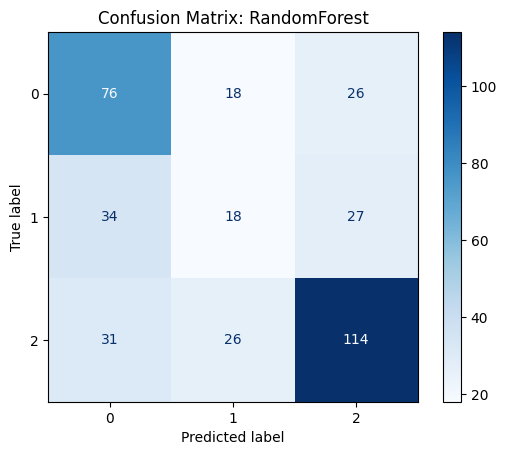

[I 2024-11-27 12:50:19,884] A new study created in memory with name: no-name-ad67cb38-2ae2-405a-a661-b06984fb1dd1


Total profit for trainmet_odds_met_balancing: 13.859999999999996
Data for trainmet_odds_met_balancing stored as resultsdf_RF_trainmet_odds_met_balancing


Running RF on dataset variant: trainmet_odds_zonder_balancing
Class distribution in training data: Counter({2: 821, 0: 613, 1: 414})


[I 2024-11-27 12:50:20,387] Trial 0 finished with value: 0.5167845894675163 and parameters: {'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5167845894675163.
[I 2024-11-27 12:50:20,981] Trial 1 finished with value: 0.530309822017139 and parameters: {'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.530309822017139.
[I 2024-11-27 12:50:21,395] Trial 2 finished with value: 0.5297692814765986 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.530309822017139.
[I 2024-11-27 12:50:22,025] Trial 3 finished with value: 0.5281476598549769 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features':

Best hyperparameters: {'n_estimators': 166, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}
Test set accuracy: 0.5865
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       120
           1       0.00      0.00      0.00        79
           2       0.63      0.78      0.69       171

    accuracy                           0.59       370
   macro avg       0.39      0.49      0.43       370
weighted avg       0.46      0.59      0.52       370



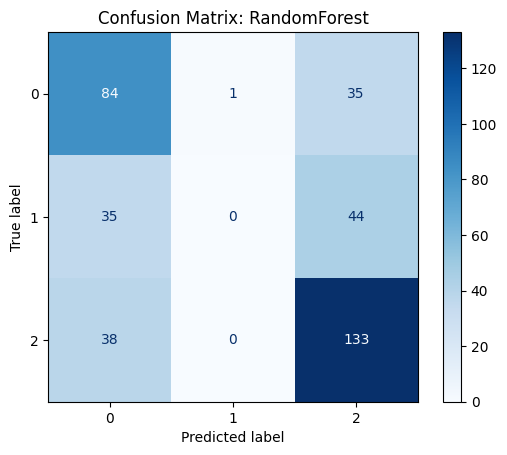

[I 2024-11-27 12:50:39,769] A new study created in memory with name: no-name-507ad7fe-9cae-4d93-926d-1951ad5a4e59


Total profit for trainmet_odds_zonder_balancing: -0.7000000000000011
Data for trainmet_odds_zonder_balancing stored as resultsdf_RF_trainmet_odds_zonder_balancing


Running RF on dataset variant: trainzonder_odds_met_balancing
Class distribution in training data: Counter({0: 821, 2: 821, 1: 821})


[I 2024-11-27 12:50:40,819] Trial 0 finished with value: 0.5485545605963159 and parameters: {'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5485545605963159.
[I 2024-11-27 12:50:42,040] Trial 1 finished with value: 0.5278409934200761 and parameters: {'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5485545605963159.
[I 2024-11-27 12:50:42,819] Trial 2 finished with value: 0.52540031992612 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5485545605963159.
[I 2024-11-27 12:50:43,769] Trial 3 finished with value: 0.5335246293639406 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features'

Best hyperparameters: {'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Test set accuracy: 0.5514
              precision    recall  f1-score   support

           0       0.57      0.58      0.58       120
           1       0.31      0.33      0.32        79
           2       0.66      0.63      0.64       171

    accuracy                           0.55       370
   macro avg       0.51      0.51      0.51       370
weighted avg       0.56      0.55      0.55       370



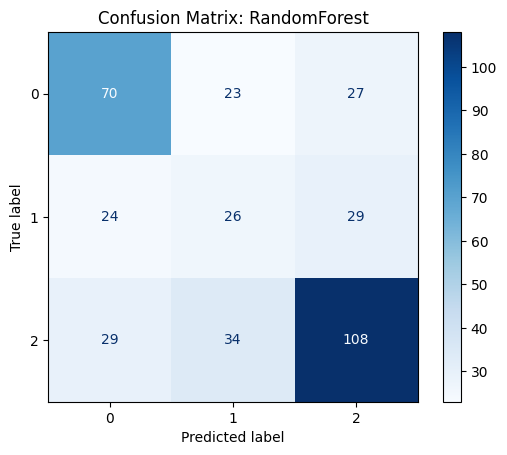

[I 2024-11-27 12:51:21,666] A new study created in memory with name: no-name-490d1341-2e00-4809-9f36-71f431138ca6


Total profit for trainzonder_odds_met_balancing: 33.48999999999999
Data for trainzonder_odds_met_balancing stored as resultsdf_RF_trainzonder_odds_met_balancing


Running RF on dataset variant: trainzonder_odds_zonder_balancing
Class distribution in training data: Counter({2: 821, 0: 613, 1: 414})


[I 2024-11-27 12:51:22,336] Trial 0 finished with value: 0.49564930784442984 and parameters: {'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.49564930784442984.
[I 2024-11-27 12:51:23,106] Trial 1 finished with value: 0.503222734930052 and parameters: {'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.503222734930052.
[I 2024-11-27 12:51:23,622] Trial 2 finished with value: 0.5059298322712956 and parameters: {'n_estimators': 95, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.5059298322712956.
[I 2024-11-27 12:51:24,291] Trial 3 finished with value: 0.507539734856808 and parameters: {'n_estimators': 118, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features

Best hyperparameters: {'n_estimators': 187, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}
Test set accuracy: 0.5622
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       120
           1       0.00      0.00      0.00        79
           2       0.58      0.82      0.68       171

    accuracy                           0.56       370
   macro avg       0.37      0.46      0.41       370
weighted avg       0.44      0.56      0.49       370



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


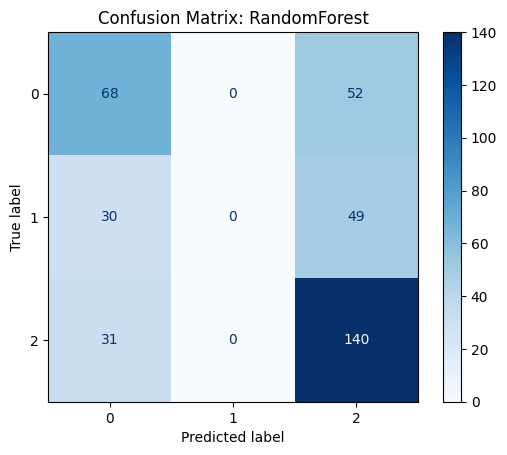

Total profit for trainzonder_odds_zonder_balancing: -3.589999999999999
Data for trainzonder_odds_zonder_balancing stored as resultsdf_RF_trainzonder_odds_zonder_balancing


resultsdf_RF_trainmet_odds_met_balancing:
    Predicted  Actual  B365H  B365D  B365A  Profit
0          2       2   1.95    3.4   4.00    0.95
1          0       0   2.70    3.3   2.63    1.63
2          2       2   1.20    7.0  13.00    0.20
3          0       0   4.00    3.8   1.85    0.85
4          2       2   2.80    3.6   2.38    1.80

resultsdf_RF_trainmet_odds_zonder_balancing:
    Predicted  Actual  B365H  B365D  B365A  Profit
0          2       2   1.95    3.4   4.00    0.95
1          0       0   2.70    3.3   2.63    1.63
2          2       2   1.20    7.0  13.00    0.20
3          0       0   4.00    3.8   1.85    0.85
4          0       2   2.80    3.6   2.38   -1.00

resultsdf_RF_trainzonder_odds_met_balancing:
    Predicted  Actual  B365H  B365D  B365A  Profit
0          2       2   1.95    3.4   4.0

In [23]:
def calculate_profit(y_pred, y_test, odds, stake=1):
    profit = 0
    for prediction, actual, odd in zip(y_pred, y_test, odds):
        if prediction == actual:
            if prediction == 2:
                profit += stake * odd[0] - stake  # B365H
            elif prediction == 1:
                profit += stake * odd[1] - stake  # B365D
            elif prediction == 0:
                profit += stake * odd[2] - stake  # B365A
        else:
            profit -= stake
    return profit

results_dict = {}

def tune_and_evaluate_rf_optuna(X_train, y_train, X_test, y_test, odds_test):
    def objective_rf(trial):
        rf_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200), 
            'max_depth': trial.suggest_int('max_depth', 3, 10),  
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 11),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),  
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]) 
        }

        rf = RandomForestClassifier(random_state=42, **rf_params)
        pipeline = Pipeline([('rf', rf)])

        accuracy_scorer = make_scorer(accuracy_score)
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=accuracy_scorer, n_jobs=-1)
        
        return np.mean(scores)

    study_rf = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study_rf.optimize(objective_rf, n_trials=30)

    print("Best hyperparameters:", study_rf.best_params)

    best_params = study_rf.best_params
    rf_tuned = RandomForestClassifier(random_state=42, **best_params)
    rf_tuned.fit(X_train, y_train)
    y_pred = rf_tuned.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix: RandomForest")
    plt.show()

    total_profit = calculate_profit(y_pred, y_test, odds_test)

    return rf_tuned, y_pred


for variant_name, (X_train, y_train) in datasets.items():
    if 'test' in variant_name:  
        continue  
    
    print(f"\nRunning RF on dataset variant: {variant_name}")

    print("Class distribution in training data:", Counter(y_train))

    if variant_name == 'trainmet_odds_met_balancing':
        X_test = datasets['testmet_odds_met_balancing'][0]
        y_test = datasets['testmet_odds_met_balancing'][1]
        odds_test = X_test[['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainmet_odds_zonder_balancing':
        X_test = datasets['testmet_odds_zonder_balancing'][0]
        y_test = datasets['testmet_odds_zonder_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainzonder_odds_met_balancing':
        X_test = datasets['testzonder_odds_met_balancing'][0]
        y_test = datasets['testzonder_odds_met_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainzonder_odds_zonder_balancing':
        X_test = datasets['testzonder_odds_zonder_balancing'][0]
        y_test = datasets['testzonder_odds_zonder_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    else:
        print(f"Variant name {variant_name} does not match any known test set, skipping.")
        continue
    
    X_train = X_train.values 
    y_train = y_train.values 
    X_test = X_test.values  
    y_test = y_test.values  
    
    if X_test is None or y_test is None:
        print(f"Test data for {variant_name} is invalid. Skipping.")
        continue

    best_model, y_pred = tune_and_evaluate_rf_optuna(X_train, y_train, X_test, y_test, odds_test)

    variant_results = []
    total_profit = 0

    for i in range(len(y_pred)):
        match_profit = calculate_profit([y_pred[i]], [y_test[i]], [odds_test[i]])
        variant_results.append({
            'Predicted': y_pred[i],
            'Actual': y_test[i],
            'B365H': odds_test[i][0],
            'B365D': odds_test[i][1],
            'B365A': odds_test[i][2],
            'Profit': match_profit
        })
        total_profit += match_profit

    print(f"Total profit for {variant_name}: {total_profit}")

    results_df = pd.DataFrame(variant_results)
    results_dict[f"resultsdf_RF_{variant_name}"] = results_df

    print(f"Data for {variant_name} stored as resultsdf_RF_{variant_name}\n")

for name, df in results_dict.items():
    print(f"\n{name}:\n", df.head())

[I 2024-11-27 19:15:01,204] A new study created in memory with name: no-name-d554b209-bfec-4303-9b8a-06fad2b4ce53



Running XGBoost on dataset variant: trainmet_odds_met_balancing


[I 2024-11-27 19:15:04,167] Trial 0 finished with value: 0.5696820528043008 and parameters: {'n_estimators': 106, 'learning_rate': 0.047585001014085894, 'max_depth': 8, 'subsample': 0.7993292420985183, 'min_child_weight': 2, 'colsample_bytree': 0.5779972601681014}. Best is trial 0 with value: 0.5696820528043008.
[I 2024-11-27 19:15:04,916] Trial 1 finished with value: 0.55221557083725 and parameters: {'n_estimators': 58, 'learning_rate': 0.043442631142971824, 'max_depth': 7, 'subsample': 0.8540362888980227, 'min_child_weight': 1, 'colsample_bytree': 0.9849549260809971}. Best is trial 0 with value: 0.5696820528043008.
[I 2024-11-27 19:15:05,614] Trial 2 finished with value: 0.518899553092894 and parameters: {'n_estimators': 175, 'learning_rate': 0.011404616423235533, 'max_depth': 4, 'subsample': 0.5917022549267169, 'min_child_weight': 4, 'colsample_bytree': 0.762378215816119}. Best is trial 0 with value: 0.5696820528043008.
[I 2024-11-27 19:15:06,515] Trial 3 finished with value: 0.5485

Best hyperparameters: {'n_estimators': 129, 'learning_rate': 0.049876021595567685, 'max_depth': 10, 'subsample': 0.7849527378148702, 'min_child_weight': 2, 'colsample_bytree': 0.6120216069637563}
Test set accuracy: 0.5541
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       120
           1       0.20      0.14      0.16        79
           2       0.63      0.72      0.67       171

    accuracy                           0.55       370
   macro avg       0.47      0.48      0.48       370
weighted avg       0.53      0.55      0.54       370



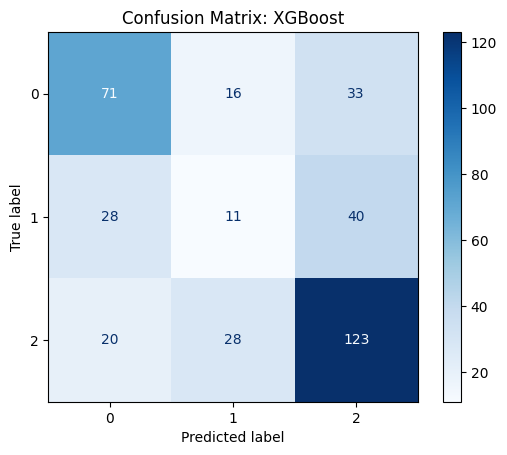

[I 2024-11-27 19:15:40,496] A new study created in memory with name: no-name-7e0b9c24-b4b1-401b-b0d0-2b36b8a90181


Total profit for trainmet_odds_met_balancing: 5.439999999999986
Data for trainmet_odds_met_balancing stored as resultsdf_RF_trainmet_odds_met_balancing


Running XGBoost on dataset variant: trainmet_odds_zonder_balancing


[I 2024-11-27 19:15:40,902] Trial 0 finished with value: 0.5059591298615689 and parameters: {'n_estimators': 106, 'learning_rate': 0.047585001014085894, 'max_depth': 8, 'subsample': 0.7993292420985183, 'min_child_weight': 2, 'colsample_bytree': 0.5779972601681014}. Best is trial 0 with value: 0.5059591298615689.
[I 2024-11-27 19:15:41,175] Trial 1 finished with value: 0.520577162528382 and parameters: {'n_estimators': 58, 'learning_rate': 0.043442631142971824, 'max_depth': 7, 'subsample': 0.8540362888980227, 'min_child_weight': 1, 'colsample_bytree': 0.9849549260809971}. Best is trial 1 with value: 0.520577162528382.
[I 2024-11-27 19:15:41,609] Trial 2 finished with value: 0.5384311140408701 and parameters: {'n_estimators': 175, 'learning_rate': 0.011404616423235533, 'max_depth': 4, 'subsample': 0.5917022549267169, 'min_child_weight': 4, 'colsample_bytree': 0.762378215816119}. Best is trial 2 with value: 0.5384311140408701.
[I 2024-11-27 19:15:42,126] Trial 3 finished with value: 0.525

Best hyperparameters: {'n_estimators': 142, 'learning_rate': 0.014241138185489662, 'max_depth': 5, 'subsample': 0.6020914931801977, 'min_child_weight': 7, 'colsample_bytree': 0.5505854790099324}
Test set accuracy: 0.5892
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       120
           1       0.00      0.00      0.00        79
           2       0.63      0.78      0.70       171

    accuracy                           0.59       370
   macro avg       0.39      0.50      0.44       370
weighted avg       0.46      0.59      0.52       370



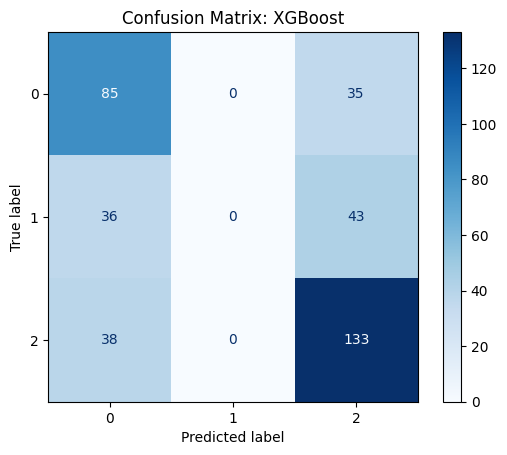

[I 2024-11-27 19:15:53,345] A new study created in memory with name: no-name-d2e2003a-ceb8-40a8-aa76-fd2247b6f985


Total profit for trainmet_odds_zonder_balancing: 7.749999999999992
Data for trainmet_odds_zonder_balancing stored as resultsdf_RF_trainmet_odds_zonder_balancing


Running XGBoost on dataset variant: trainzonder_odds_met_balancing


[I 2024-11-27 19:15:54,276] Trial 0 finished with value: 0.5501822259601907 and parameters: {'n_estimators': 106, 'learning_rate': 0.047585001014085894, 'max_depth': 8, 'subsample': 0.7993292420985183, 'min_child_weight': 2, 'colsample_bytree': 0.5779972601681014}. Best is trial 0 with value: 0.5501822259601907.
[I 2024-11-27 19:15:54,965] Trial 1 finished with value: 0.5440830158808687 and parameters: {'n_estimators': 58, 'learning_rate': 0.043442631142971824, 'max_depth': 7, 'subsample': 0.8540362888980227, 'min_child_weight': 1, 'colsample_bytree': 0.9849549260809971}. Best is trial 0 with value: 0.5501822259601907.
[I 2024-11-27 19:15:55,632] Trial 2 finished with value: 0.5038687973086627 and parameters: {'n_estimators': 175, 'learning_rate': 0.011404616423235533, 'max_depth': 4, 'subsample': 0.5917022549267169, 'min_child_weight': 4, 'colsample_bytree': 0.762378215816119}. Best is trial 0 with value: 0.5501822259601907.
[I 2024-11-27 19:15:56,558] Trial 3 finished with value: 0.5

Best hyperparameters: {'n_estimators': 144, 'learning_rate': 0.018046202637800254, 'max_depth': 10, 'subsample': 0.7572792965555748, 'min_child_weight': 1, 'colsample_bytree': 0.90717604919467}
Test set accuracy: 0.5459
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       120
           1       0.29      0.29      0.29        79
           2       0.64      0.65      0.64       171

    accuracy                           0.55       370
   macro avg       0.50      0.50      0.50       370
weighted avg       0.55      0.55      0.55       370



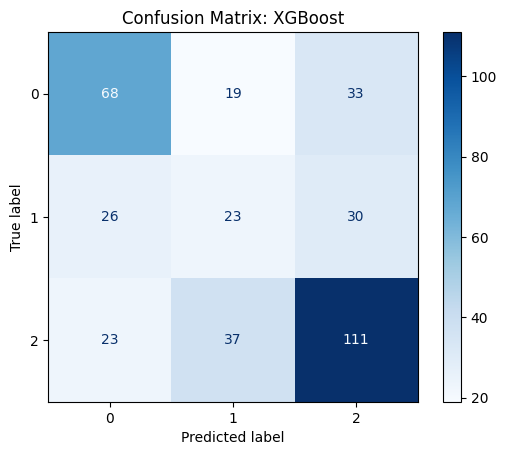

[I 2024-11-27 19:16:35,053] A new study created in memory with name: no-name-5f07d754-9e42-4071-8939-6ddfd38cad78


Total profit for trainzonder_odds_met_balancing: 32.87
Data for trainzonder_odds_met_balancing stored as resultsdf_RF_trainzonder_odds_met_balancing


Running XGBoost on dataset variant: trainzonder_odds_zonder_balancing


[I 2024-11-27 19:16:35,584] Trial 0 finished with value: 0.4929466051417271 and parameters: {'n_estimators': 106, 'learning_rate': 0.047585001014085894, 'max_depth': 8, 'subsample': 0.7993292420985183, 'min_child_weight': 2, 'colsample_bytree': 0.5779972601681014}. Best is trial 0 with value: 0.4929466051417271.
[I 2024-11-27 19:16:35,909] Trial 1 finished with value: 0.5053863619717278 and parameters: {'n_estimators': 58, 'learning_rate': 0.043442631142971824, 'max_depth': 7, 'subsample': 0.8540362888980227, 'min_child_weight': 1, 'colsample_bytree': 0.9849549260809971}. Best is trial 1 with value: 0.5053863619717278.
[I 2024-11-27 19:16:36,364] Trial 2 finished with value: 0.514575551160917 and parameters: {'n_estimators': 175, 'learning_rate': 0.011404616423235533, 'max_depth': 4, 'subsample': 0.5917022549267169, 'min_child_weight': 4, 'colsample_bytree': 0.762378215816119}. Best is trial 2 with value: 0.514575551160917.
[I 2024-11-27 19:16:36,831] Trial 3 finished with value: 0.512

Best hyperparameters: {'n_estimators': 176, 'learning_rate': 0.00516504117880041, 'max_depth': 6, 'subsample': 0.5260425851574494, 'min_child_weight': 7, 'colsample_bytree': 0.6163624968902534}
Test set accuracy: 0.5757
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       120
           1       0.00      0.00      0.00        79
           2       0.59      0.83      0.69       171

    accuracy                           0.58       370
   macro avg       0.38      0.47      0.42       370
weighted avg       0.45      0.58      0.50       370



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


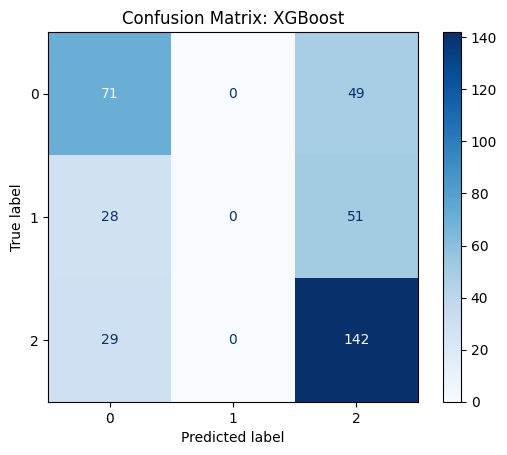

Total profit for trainzonder_odds_zonder_balancing: 16.010000000000005
Data for trainzonder_odds_zonder_balancing stored as resultsdf_RF_trainzonder_odds_zonder_balancing


resultsdf_RF_trainmet_odds_met_balancing:
    Predicted  Actual  B365H  B365D  B365A  Profit
0          2       2   1.95    3.4   4.00    0.95
1          2       0   2.70    3.3   2.63   -1.00
2          2       2   1.20    7.0  13.00    0.20
3          2       0   4.00    3.8   1.85   -1.00
4          1       2   2.80    3.6   2.38   -1.00

resultsdf_RF_trainmet_odds_zonder_balancing:
    Predicted  Actual  B365H  B365D  B365A  Profit
0          2       2   1.95    3.4   4.00    0.95
1          0       0   2.70    3.3   2.63    1.63
2          2       2   1.20    7.0  13.00    0.20
3          0       0   4.00    3.8   1.85    0.85
4          2       2   2.80    3.6   2.38    1.80

resultsdf_RF_trainzonder_odds_met_balancing:
    Predicted  Actual  B365H  B365D  B365A  Profit
0          2       2   1.95    3.4   4.0

In [18]:
def calculate_profit(y_pred, y_test, odds, stake=1):
    profit = 0
    for prediction, actual, odd in zip(y_pred, y_test, odds):
        if prediction == actual:
            if prediction == 2:
                profit += stake * odd[0] - stake  # B365H
            elif prediction == 1:
                profit += stake * odd[1] - stake  # B365D
            elif prediction == 0:
                profit += stake * odd[2] - stake  # B365A
        else:
            profit -= stake
    return profit

def tune_and_evaluate_xgb_optuna(X_train, y_train, X_test, y_test, odds_test):
    def objective_xgb(trial):
        xgb_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),  # Number of trees
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),  # Learning rate
            'max_depth': trial.suggest_int('max_depth', 3, 10),  # Maximum depth of trees
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fraction of samples to use in each tree
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Minimum child weight
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fraction of samples to use in each tree
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)  # Fraction of features for each tree
        }

        xgb = XGBClassifier(random_state=42, **xgb_params)
        pipeline = Pipeline([('xgb', xgb)])
        accuracy_scorer = make_scorer(accuracy_score)
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=accuracy_scorer, n_jobs=-1)
        return np.mean(scores)

    study_xgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study_xgb.optimize(objective_xgb, n_trials=30)
    
    print("Best hyperparameters:", study_xgb.best_params)

    best_params = study_xgb.best_params
    xgb_tuned = XGBClassifier(random_state=42, **best_params)
    xgb_tuned.fit(X_train, y_train)
    y_pred = xgb_tuned.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix: XGBoost")
    plt.show()

    total_profit = calculate_profit(y_pred, y_test, odds_test)

    return xgb_tuned, y_pred

results_dict = {}

for variant_name, (X_train, y_train) in datasets.items():
    if 'test' in variant_name:
        continue  

    print(f"\nRunning XGBoost on dataset variant: {variant_name}")

    if variant_name == 'trainmet_odds_met_balancing':
        X_test = datasets['testmet_odds_met_balancing'][0]
        y_test = datasets['testmet_odds_met_balancing'][1]
        odds_test = X_test[['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainmet_odds_zonder_balancing':
        X_test = datasets['testmet_odds_zonder_balancing'][0]
        y_test = datasets['testmet_odds_zonder_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainzonder_odds_met_balancing':
        X_test = datasets['testzonder_odds_met_balancing'][0]
        y_test = datasets['testzonder_odds_met_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainzonder_odds_zonder_balancing':
        X_test = datasets['testzonder_odds_zonder_balancing'][0]
        y_test = datasets['testzonder_odds_zonder_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    else:
        print(f"Unknown variant name {variant_name}, skipping.")
        continue

    X_train = X_train.values
    y_train = y_train.values
    X_test = X_test.values
    y_test = y_test.values

    best_model, y_pred = tune_and_evaluate_xgb_optuna(X_train, y_train, X_test, y_test, odds_test)

    variant_results = []
    total_profit = 0

    for i in range(len(y_pred)):
        match_profit = calculate_profit([y_pred[i]], [y_test[i]], [odds_test[i]])
        variant_results.append({
            'Predicted': y_pred[i],
            'Actual': y_test[i],
            'B365H': odds_test[i][0],
            'B365D': odds_test[i][1],
            'B365A': odds_test[i][2],
            'Profit': match_profit
        })
        total_profit += match_profit

    print(f"Total profit for {variant_name}: {total_profit}")

    results_df = pd.DataFrame(variant_results)
    results_dict[f"resultsdf_RF_{variant_name}"] = results_df

    print(f"Data for {variant_name} stored as resultsdf_RF_{variant_name}\n")

for name, df in results_dict.items():
    print(f"\n{name}:\n", df.head())




[I 2024-11-27 13:29:43,242] A new study created in memory with name: no-name-33bf99c7-1b24-4e9d-bdd6-17475df8841f



Running TabNet on dataset variant: trainmet_odds_met_balancing
Class distribution in training data: Counter({0: 821, 2: 821, 1: 821})


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 13:32:19,878] Trial 0 finished with value: 0.5172578703474662 and parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 7, 'gamma': 0.04, 'n_shared': 1, 'lamb

Best parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 8, 'gamma': 0.02, 'n_shared': 2, 'lambda_sparse': 7.891392918016076e-05, 'patienceScheduler': 9, 'max_epochs': 50, 'patience': 7}

Early stopping occurred at epoch 12 with best_epoch = 5 and best_val_0_accuracy = 0.54595
TabNet - Accuracy: 0.5459, F1-score: 0.4840


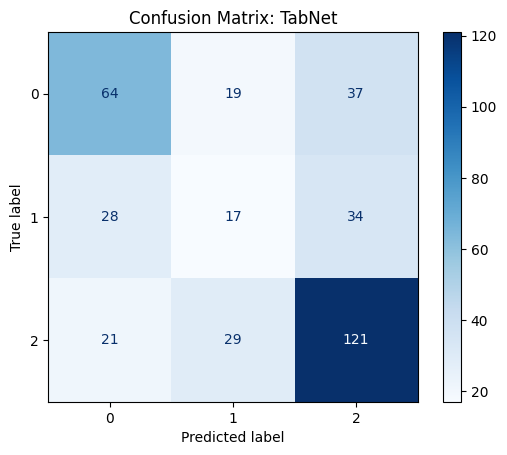

[I 2024-11-27 15:05:39,899] A new study created in memory with name: no-name-59209e8e-e618-4daf-b085-bfee8b150690


              precision    recall  f1-score   support

     class_1       0.57      0.53      0.55       120
     class_2       0.26      0.22      0.24        79
     class_3       0.63      0.71      0.67       171

    accuracy                           0.55       370
   macro avg       0.49      0.49      0.48       370
weighted avg       0.53      0.55      0.54       370

Model saved as 'tabnet_model.pth'
Total profit for trainmet_odds_met_balancing: 15.929999999999994
Data for trainmet_odds_met_balancing stored as resultsdf_RF_trainmet_odds_met_balancing


Running TabNet on dataset variant: trainmet_odds_zonder_balancing
Class distribution in training data: Counter({2: 821, 0: 613, 1: 414})


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 15:06:45,348] Trial 0 finished with value: 0.5470812275690325 and parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 7, 'gamma': 0.04, 'n_shared': 1, 'lamb

Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.83069
Stop training because you reached max_epochs = 27 with best_epoch = 26 and best_val_0_accuracy = 0.78197
Stop training because you reached max_epochs = 34 with best_epoch = 30 and best_val_0_accuracy = 0.76248
Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.57856
Stop training because you reached max_epochs = 38 with best_epoch = 37 and best_val_0_accuracy = 0.66423
Stop training because you reached max_epochs = 38 with best_epoch = 35 and best_val_0_accuracy = 0.57613
Stop training because you reached max_epochs = 32 with best_epoch = 30 and best_val_0_accuracy = 0.69265
Stop training because you reached max_epochs = 32 with best_epoch = 29 and best_val_0_accuracy = 0.6553
Stop training because you reached max_epochs = 11 with best_epoch = 10 and best_val_0_accuracy = 0.63175
Stop training because you reached max_epochs = 13 with b

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 15:30:54,221] Trial 27 finished with value: 0.554657584413682 and parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 6, 'gamma': 0.03, 'n_shared': 2, 'lamb

Best parameters: {'mask_type': 'entmax', 'n_da': 16, 'n_steps': 5, 'gamma': 0.09999999999999999, 'n_shared': 3, 'lambda_sparse': 0.00035632918778922634, 'patienceScheduler': 8, 'max_epochs': 29, 'patience': 5}

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_accuracy = 0.61622
TabNet - Accuracy: 0.6162, F1-score: 0.4694


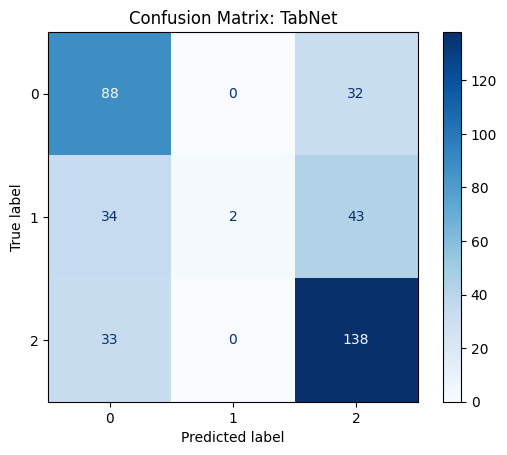

[I 2024-11-27 15:33:04,110] A new study created in memory with name: no-name-a4596a6a-112c-4f01-8c9b-aad74534909a


              precision    recall  f1-score   support

     class_1       0.57      0.73      0.64       120
     class_2       1.00      0.03      0.05        79
     class_3       0.65      0.81      0.72       171

    accuracy                           0.62       370
   macro avg       0.74      0.52      0.47       370
weighted avg       0.70      0.62      0.55       370

Model saved as 'tabnet_model.pth'
Total profit for trainmet_odds_zonder_balancing: 38.019999999999996
Data for trainmet_odds_zonder_balancing stored as resultsdf_RF_trainmet_odds_zonder_balancing


Running TabNet on dataset variant: trainzonder_odds_met_balancing
Class distribution in training data: Counter({0: 821, 2: 821, 1: 821})


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 15:35:29,296] Trial 0 finished with value: 0.5558798792856082 and parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 7, 'gamma': 0.04, 'n_shared': 1, 'lamb

Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.83354
Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.74178
Stop training because you reached max_epochs = 27 with best_epoch = 25 and best_val_0_accuracy = 0.76289
Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.76451
Stop training because you reached max_epochs = 38 with best_epoch = 31 and best_val_0_accuracy = 0.67479
Stop training because you reached max_epochs = 32 with best_epoch = 31 and best_val_0_accuracy = 0.71092
Stop training because you reached max_epochs = 11 with best_epoch = 10 and best_val_0_accuracy = 0.6354
Stop training because you reached max_epochs = 13 with best_epoch = 12 and best_val_0_accuracy = 0.60698
Stop training because you reached max_epochs = 24 with best_epoch = 23 and best_val_0_accuracy = 0.68006
Stop training because you reached max_epochs = 46 with b

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 15:49:25,002] Trial 5 finished with value: 0.4299411269974769 and parameters: {'mask_type': 'entmax', 'n_da': 32, 'n_steps': 10, 'gamma': 0.12, 'n_shared': 3, 'lambda

Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.80309
Stop training because you reached max_epochs = 27 with best_epoch = 26 and best_val_0_accuracy = 0.66748
Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.76411
Stop training because you reached max_epochs = 38 with best_epoch = 37 and best_val_0_accuracy = 0.69062
Stop training because you reached max_epochs = 32 with best_epoch = 30 and best_val_0_accuracy = 0.69306
Stop training because you reached max_epochs = 11 with best_epoch = 10 and best_val_0_accuracy = 0.63175
Stop training because you reached max_epochs = 11 with best_epoch = 10 and best_val_0_accuracy = 0.53065
Stop training because you reached max_epochs = 13 with best_epoch = 12 and best_val_0_accuracy = 0.60739
Stop training because you reached max_epochs = 13 with best_epoch = 11 and best_val_0_accuracy = 0.5741
Stop training because you reached max_epochs = 24 with b

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 15:55:54,474] Trial 9 finished with value: 0.42466481967050906 and parameters: {'mask_type': 'sparsemax', 'n_da': 32, 'n_steps': 7, 'gamma': 0.16, 'n_shared': 2, 'lambda_sparse': 3.69997243146381e-05, 'patienceScheduler': 7, 'max_epochs': 11, 'patience': 5}. Best is trial 0 with value: 0.5558798792856082.
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.

Stop training because you reached max_epochs = 34 with best_epoch = 31 and best_val_0_accuracy = 0.8242
Stop training because you reached max_epochs = 27 with best_epoch = 25 and best_val_0_accuracy = 0.76695
Stop training because you reached max_epochs = 27 with best_epoch = 24 and best_val_0_accuracy = 0.71133
Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.72757
Stop training because you reached max_epochs = 38 with best_epoch = 36 and best_val_0_accuracy = 0.69996
Stop training because you reached max_epochs = 32 with best_epoch = 31 and best_val_0_accuracy = 0.71864
Stop training because you reached max_epochs = 11 with best_epoch = 9 and best_val_0_accuracy = 0.635
Stop training because you reached max_epochs = 13 with best_epoch = 12 and best_val_0_accuracy = 0.63256
Stop training because you reached max_epochs = 24 with best_epoch = 23 and best_val_0_accuracy = 0.66707
Stop training because you reached max_epochs = 46 with best

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 16:07:02,889] Trial 12 finished with value: 0.5765967446692722 and parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 8, 'gamma': 0.01, 'n_shared': 1, 'lambda_sparse': 5.097139359389593e-05, 'patienceScheduler': 10, 'max_epochs': 50, 'patience': 10}. Best is trial 12 with value: 0.5765967446692722.
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/pyth

Best parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 8, 'gamma': 0.01, 'n_shared': 1, 'lambda_sparse': 5.097139359389593e-05, 'patienceScheduler': 10, 'max_epochs': 50, 'patience': 10}

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.55405
TabNet - Accuracy: 0.5541, F1-score: 0.4934


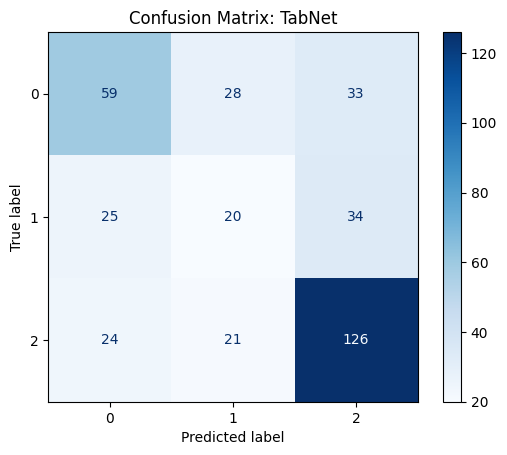

[I 2024-11-27 17:04:58,078] A new study created in memory with name: no-name-57296a5c-5ce5-4a93-bee4-aec7a2a14b1f


              precision    recall  f1-score   support

     class_1       0.55      0.49      0.52       120
     class_2       0.29      0.25      0.27        79
     class_3       0.65      0.74      0.69       171

    accuracy                           0.55       370
   macro avg       0.50      0.49      0.49       370
weighted avg       0.54      0.55      0.55       370

Model saved as 'tabnet_model.pth'
Total profit for trainzonder_odds_met_balancing: 34.879999999999995
Data for trainzonder_odds_met_balancing stored as resultsdf_RF_trainzonder_odds_met_balancing


Running TabNet on dataset variant: trainzonder_odds_zonder_balancing
Class distribution in training data: Counter({2: 821, 0: 613, 1: 414})


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 17:06:48,091] Trial 0 finished with value: 0.4896799238262653 and parameters: {'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 7, 'gamma': 0.04, 'n_shared': 1, 'lamb

Stop training because you reached max_epochs = 17 with best_epoch = 11 and best_val_0_accuracy = 0.55628
Stop training because you reached max_epochs = 17 with best_epoch = 13 and best_val_0_accuracy = 0.55411
Stop training because you reached max_epochs = 16 with best_epoch = 14 and best_val_0_accuracy = 0.55898
Stop training because you reached max_epochs = 18 with best_epoch = 14 and best_val_0_accuracy = 0.55411
Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.87657
Stop training because you reached max_epochs = 34 with best_epoch = 30 and best_val_0_accuracy = 0.87739
Stop training because you reached max_epochs = 27 with best_epoch = 26 and best_val_0_accuracy = 0.8177
Stop training because you reached max_epochs = 34 with best_epoch = 33 and best_val_0_accuracy = 0.80796
Stop training because you reached max_epochs = 38 with best_epoch = 36 and best_val_0_accuracy = 0.73244
Stop training because you reached max_epochs = 38 with b

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-27 17:32:45,238] Trial 20 finished with value: 0.4956331941697796 and parameters: {'mask_type': 'entmax', 'n_da': 24, 'n_steps': 8, 'gamma': 0.13, 'n_shared': 1, 'lambda_sparse': 3.224633716323199e-06, 'patienceScheduler': 7, 'max_epochs': 18, 'patience': 7}. Best is trial 16 with value: 0.5107844429795649.
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.1

Best parameters: {'mask_type': 'sparsemax', 'n_da': 16, 'n_steps': 3, 'gamma': 0.060000000000000005, 'n_shared': 1, 'lambda_sparse': 0.0002059204000149221, 'patienceScheduler': 10, 'max_epochs': 16, 'patience': 9}

Early stopping occurred at epoch 11 with best_epoch = 2 and best_val_0_accuracy = 0.58649
TabNet - Accuracy: 0.5865, F1-score: 0.4619


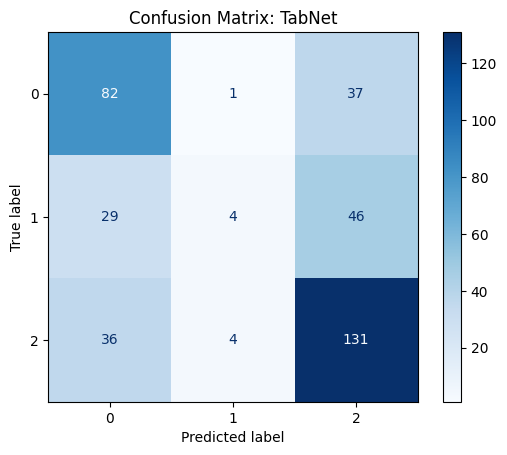

              precision    recall  f1-score   support

     class_1       0.56      0.68      0.61       120
     class_2       0.44      0.05      0.09        79
     class_3       0.61      0.77      0.68       171

    accuracy                           0.59       370
   macro avg       0.54      0.50      0.46       370
weighted avg       0.56      0.59      0.53       370

Model saved as 'tabnet_model.pth'
Total profit for trainzonder_odds_zonder_balancing: 26.859999999999978
Data for trainzonder_odds_zonder_balancing stored as resultsdf_RF_trainzonder_odds_zonder_balancing


resultsdf_RF_trainmet_odds_met_balancing:
    Predicted  Actual  B365H  B365D  B365A  Profit
0          2       2   1.95    3.4   4.00    0.95
1          0       0   2.70    3.3   2.63    1.63
2          2       2   1.20    7.0  13.00    0.20
3          0       0   4.00    3.8   1.85    0.85
4          2       2   2.80    3.6   2.38    1.80

resultsdf_RF_trainmet_odds_zonder_balancing:
    Predicted  Actual  

In [39]:
SEED = 42  
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def evaluate(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

def calculate_profit(y_pred, y_test, odds, stake=1):
    profit = 0
    for prediction, actual, odd in zip(y_pred, y_test, odds):
        if prediction == actual:
            if prediction == 2:
                profit += stake * odd[0] - stake  # B365H
            elif prediction == 1:
                profit += stake * odd[1] - stake  # B365D
            elif prediction == 0:
                profit += stake * odd[2] - stake  # B365A
        else:
            profit -= stake
    return profit

def tune_and_evaluate_tabnet(X_train, y_train, X_test, y_test, odds_test):
    def Objective_tabnet(trial):
        mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
        n_da = trial.suggest_int("n_da", 8, 32, step=8)
        n_steps = trial.suggest_int("n_steps", 3, 10, step=1)
        gamma = trial.suggest_float("gamma", 0.01, 0.2, step=0.01)
        n_shared = trial.suggest_int("n_shared", 1, 3)
        lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)

        optimizer_params = dict(lr=2e-2, weight_decay=1e-5)
        tabnet_params = dict(
            n_d=n_da, 
            n_a=n_da, 
            n_steps=n_steps, 
            gamma=gamma,
            lambda_sparse=lambda_sparse, 
            optimizer_fn=torch.optim.Adam,
            optimizer_params=optimizer_params, 
            mask_type=mask_type,
            n_shared=n_shared,
            scheduler_params=dict(
                patience=trial.suggest_int("patienceScheduler", low=5, high=10),
                min_lr=1e-5,
                factor=0.5,
            ),
            scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
            verbose=-0,
            seed=SEED  
        )

        clf_tab_opt = TabNetClassifier(**tabnet_params, device_name='cuda' if torch.cuda.is_available() else 'cpu')
        
        accuracy_scorer = make_scorer(accuracy_score)
        scores = cross_val_score(
            clf_tab_opt, 
            X_train,
            y_train, 
            cv=5,
            n_jobs=-1,
            scoring=accuracy_scorer, 
            fit_params={
                'eval_set': [(X_train, y_train)],
                'max_epochs': trial.suggest_int("max_epochs", 10, 50),
                'patience': trial.suggest_int("patience", low=5, high=10),
                'batch_size': 64
            }
        )
        
        accuracy = np.mean(scores)
        return accuracy

    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_tabnet = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))  # Seed voor Optuna
    study_tabnet.optimize(Objective_tabnet, n_trials=30)

    TabNet_params = study_tabnet.best_params
    print("Best parameters:", TabNet_params)

    final_params_tab = dict(
        n_d=TabNet_params['n_da'], 
        n_a=TabNet_params['n_da'], 
        n_steps=TabNet_params['n_steps'], 
        gamma=TabNet_params['gamma'],
        lambda_sparse=TabNet_params['lambda_sparse'], 
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        mask_type=TabNet_params['mask_type'], 
        n_shared=TabNet_params['n_shared'],
        scheduler_params=dict(
            patience=TabNet_params['patienceScheduler'],
            min_lr=1e-5,
            factor=0.5,
        ),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        verbose=0,
        seed=SEED  
    )

    epochs = TabNet_params['max_epochs']
    clf_tuned_tab = TabNetClassifier(**final_params_tab, device_name='cuda' if torch.cuda.is_available() else 'cpu')
    clf_tuned_tab.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        max_epochs=epochs,
        patience=TabNet_params['patience'],
        batch_size=64
    )

    y_pred_tabnet = clf_tuned_tab.predict(X_test)

    evaluate(y_test, y_pred_tabnet, "TabNet")

    cm = confusion_matrix(y_test, y_pred_tabnet)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix: TabNet")
    plt.show()

    class_names = ["class_1", "class_2", "class_3"]
    print(classification_report(y_test, y_pred_tabnet, target_names=class_names))

    torch.save(clf_tuned_tab, 'tabnet_model.pth')
    print("Model saved as 'tabnet_model.pth'")

    return clf_tuned_tab, y_pred_tabnet  

results_dict = {}

for variant_name, (X_train, y_train) in datasets.items():
    if 'test' in variant_name:  
        continue  
    
    print(f"\nRunning TabNet on dataset variant: {variant_name}")

    print("Class distribution in training data:", Counter(y_train))

    if variant_name == 'trainmet_odds_met_balancing':
        X_test = datasets['testmet_odds_met_balancing'][0]
        y_test = datasets['testmet_odds_met_balancing'][1]
        odds_test = X_test[['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainmet_odds_zonder_balancing':
        X_test = datasets['testmet_odds_zonder_balancing'][0]
        y_test = datasets['testmet_odds_zonder_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainzonder_odds_met_balancing':
        X_test = datasets['testzonder_odds_met_balancing'][0]
        y_test = datasets['testzonder_odds_met_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    elif variant_name == 'trainzonder_odds_zonder_balancing':
        X_test = datasets['testzonder_odds_zonder_balancing'][0]
        y_test = datasets['testzonder_odds_zonder_balancing'][1]
        odds_test = datasets['testmet_odds_met_balancing'][0][['B365H', 'B365D', 'B365A']].values
    else:
        print(f"Variant name {variant_name} does not match any known test set, skipping.")
        continue  
    
    X_train = X_train.values  
    y_train = y_train.values  
    X_test = X_test.values  
    y_test = y_test.values  
    
    if X_test is None or y_test is None:
        print(f"Test data for {variant_name} is invalid. Skipping.")
        continue

    best_model, y_pred = tune_and_evaluate_tabnet(X_train, y_train, X_test, y_test, odds_test)

    variant_results = []
    total_profit = 0

    for i in range(len(y_pred)):
        match_profit = calculate_profit([y_pred[i]], [y_test[i]], [odds_test[i]])
        variant_results.append({
            'Predicted': y_pred[i],
            'Actual': y_test[i],
            'B365H': odds_test[i][0],
            'B365D': odds_test[i][1],
            'B365A': odds_test[i][2],
            'Profit': match_profit
        })
        total_profit += match_profit

    print(f"Total profit for {variant_name}: {total_profit}")

    results_df = pd.DataFrame(variant_results)
    results_dict[f"resultsdf_RF_{variant_name}"] = results_df

    print(f"Data for {variant_name} stored as resultsdf_RF_{variant_name}\n")

for name, df in results_dict.items():
    print(f"\n{name}:\n", df.head())


Running Random Forest on dataset variant: trainmet_odds_met_balancing


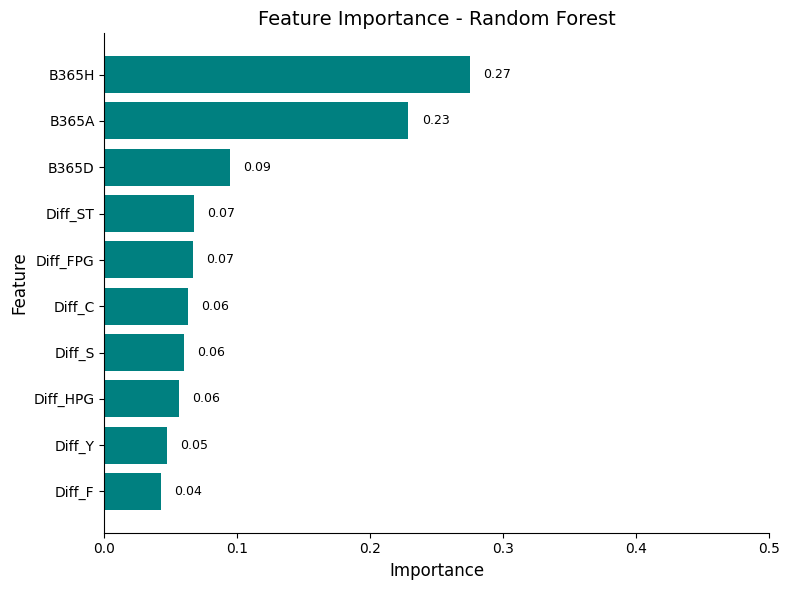

Results for trainmet_odds_met_balancing:
Accuracy: 0.5567567567567567
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       120
           1       0.27      0.25      0.26        79
           2       0.68      0.62      0.65       171

    accuracy                           0.56       370
   macro avg       0.51      0.51      0.51       370
weighted avg       0.56      0.56      0.56       370



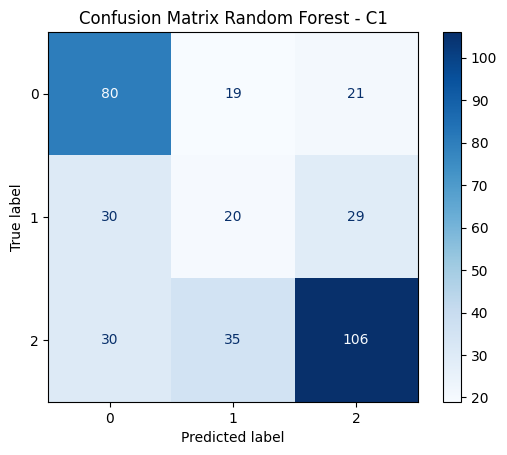


Running Random Forest on dataset variant: trainmet_odds_zonder_balancing


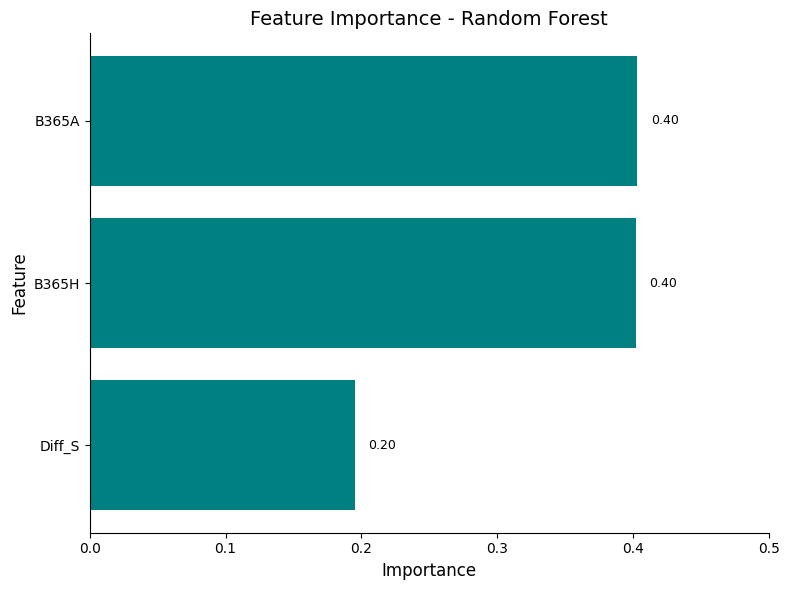

Results for trainmet_odds_zonder_balancing:
Accuracy: 0.5864864864864865
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       120
           1       0.00      0.00      0.00        79
           2       0.63      0.78      0.69       171

    accuracy                           0.59       370
   macro avg       0.39      0.49      0.43       370
weighted avg       0.46      0.59      0.52       370



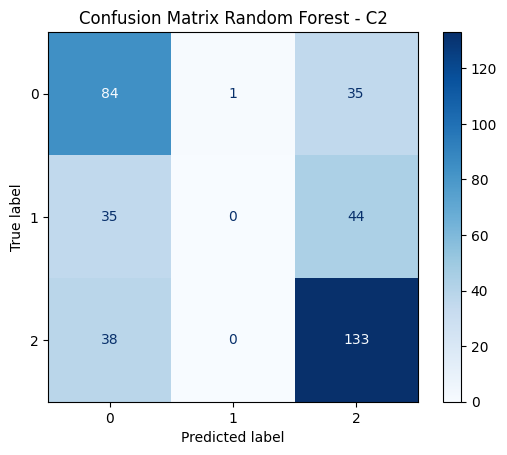


Running Random Forest on dataset variant: trainzonder_odds_met_balancing


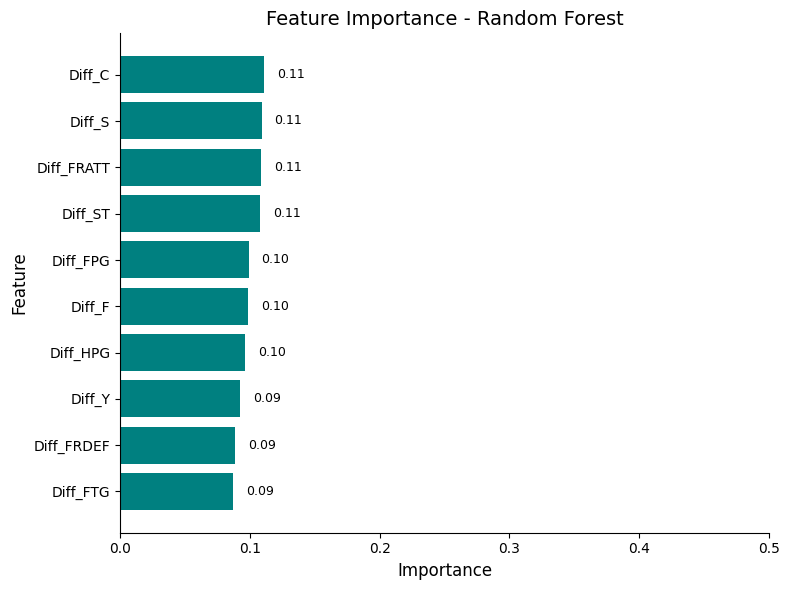

Results for trainzonder_odds_met_balancing:
Accuracy: 0.5513513513513514
              precision    recall  f1-score   support

           0       0.57      0.58      0.58       120
           1       0.31      0.33      0.32        79
           2       0.66      0.63      0.64       171

    accuracy                           0.55       370
   macro avg       0.51      0.51      0.51       370
weighted avg       0.56      0.55      0.55       370



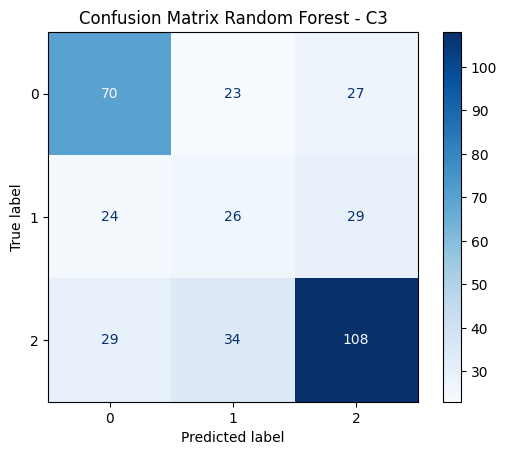


Running Random Forest on dataset variant: trainzonder_odds_zonder_balancing


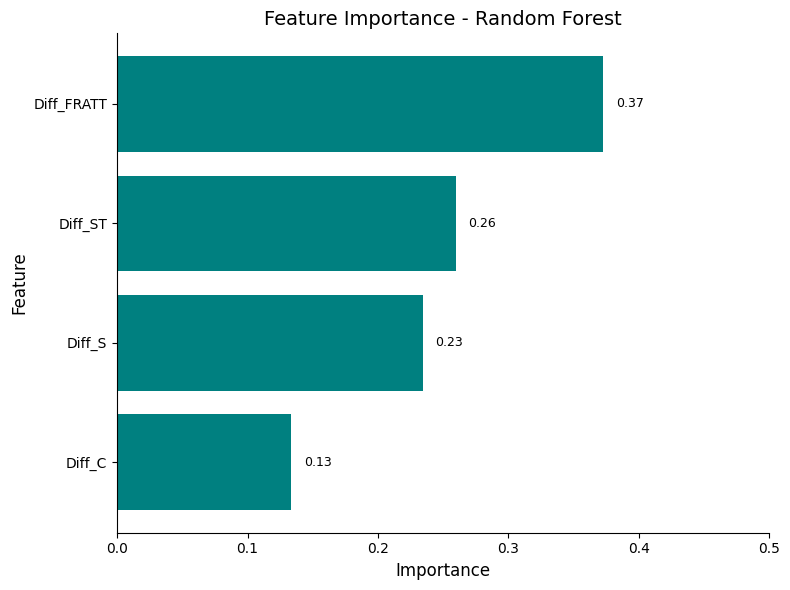

Results for trainzonder_odds_zonder_balancing:
Accuracy: 0.5621621621621622
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       120
           1       0.00      0.00      0.00        79
           2       0.58      0.82      0.68       171

    accuracy                           0.56       370
   macro avg       0.37      0.46      0.41       370
weighted avg       0.44      0.56      0.49       370



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


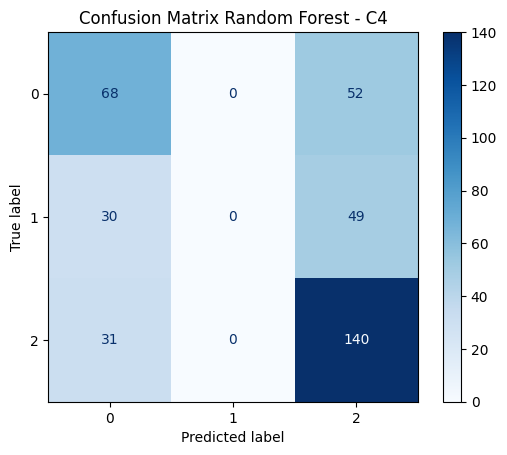

In [19]:
feature_names_dict = {
    'trainmet_odds_met_balancing': ['B365H', 'B365D', 'B365A', 'Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FPG', 'Diff_HPG'],
    'trainmet_odds_zonder_balancing': ['B365H', 'B365A', 'Diff_S'],
    'trainzonder_odds_met_balancing': ['Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FTG', 'Diff_FPG', 'Diff_HPG', 'Diff_FRDEF', 'Diff_FRATT'],
    'trainzonder_odds_zonder_balancing': ['Diff_S', 'Diff_ST', 'Diff_C', 'Diff_FRATT']
}

predefined_hyperparameters = {
    'trainmet_odds_met_balancing': {'n_estimators': 166, 'max_depth': 5, 'min_samples_split': 7,
                                    'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True},
    'trainmet_odds_zonder_balancing': {'n_estimators': 166, 'max_depth': 5, 'min_samples_split': 7,
                                       'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True},
    'trainzonder_odds_met_balancing': {'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 6,
                                       'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False},
    'trainzonder_odds_zonder_balancing': {'n_estimators': 187, 'max_depth': 3, 'min_samples_split': 5,
                                          'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}
}
variant_name_mapping = {
    'trainmet_odds_met_balancing': 'C1',
    'trainmet_odds_zonder_balancing': 'C2',
    'trainzonder_odds_met_balancing': 'C3',
    'trainzonder_odds_zonder_balancing': 'C4'
}


def generate_feature_importance_plot_rf(model, feature_names, variant_name):
    plt.figure(figsize=(8, 6))
    
    importances = model.feature_importances_
    
    indices = importances.argsort()[::1]
    
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], rotation=0, ha="right", fontsize=10)

    importance = plt.barh(range(len(indices)), importances[indices], align="center", color='teal')
    
    plt.xlim(0, 0.50)
    plt.xticks([i * 0.10 for i in range(6)], fontsize=10)  
    
    plt.grid(False)
    
    for i, value in enumerate(importances[indices]):
        plt.text(value + 0.01, i, f"{value:.2f}", va='center', fontsize=9, color='black')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.title(f"Feature Importance - Random Forest", fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"RF_Feature_Importance_{variant_name}.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
def train_and_generate_plots_rf(X_train, y_train, X_test, y_test, variant_name):
    rf_params = predefined_hyperparameters[variant_name]
    
    model = RandomForestClassifier(random_state=42, **rf_params)
    model.fit(X_train, y_train)
    
    feature_names = feature_names_dict[variant_name]

    readable_name = variant_name_mapping.get(variant_name, variant_name)
    
    generate_feature_importance_plot_rf(model, feature_names, variant_name)
    
    y_pred = model.predict(X_test)
    print(f"Results for {variant_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix Random Forest - {readable_name}")
    plt.savefig(f"RF_confusion_matrix_{variant_name}.png", bbox_inches='tight')
    plt.show()
    plt.close()

for variant_name, (X_train, y_train) in datasets.items():
    if 'test' in variant_name:  
        continue
    
    print(f"\nRunning Random Forest on dataset variant: {variant_name}")

    if variant_name == 'trainmet_odds_met_balancing':
        X_test, y_test = datasets['testmet_odds_met_balancing']
    elif variant_name == 'trainmet_odds_zonder_balancing':
        X_test, y_test = datasets['testmet_odds_zonder_balancing']
    elif variant_name == 'trainzonder_odds_met_balancing':
        X_test, y_test = datasets['testzonder_odds_met_balancing']
    elif variant_name == 'trainzonder_odds_zonder_balancing':
        X_test, y_test = datasets['testzonder_odds_zonder_balancing']
    else:
        print(f"Variant {variant_name} heeft geen bijbehorende testset. Skipping.")
        continue

    X_train = pd.DataFrame(X_train) if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=feature_names_dict[variant_name])
    X_test = pd.DataFrame(X_test) if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test, columns=feature_names_dict[variant_name])
    
    train_and_generate_plots_rf(X_train, y_train, X_test, y_test, variant_name)





Running XGBoost for trainmet_odds_met_balancing


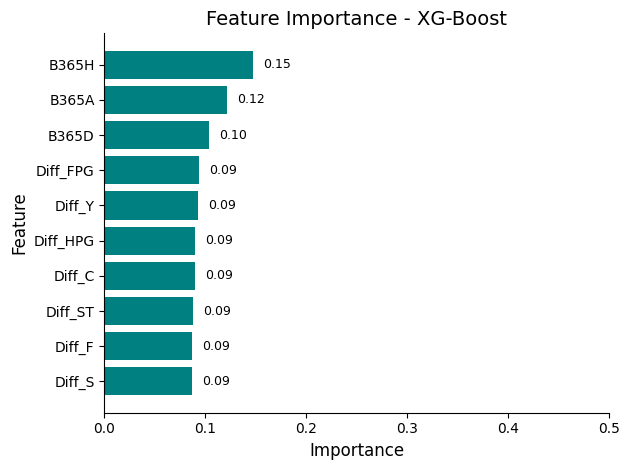

Results for trainmet_odds_met_balancing:
Accuracy: 0.5540540540540541
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       120
           1       0.20      0.14      0.16        79
           2       0.63      0.72      0.67       171

    accuracy                           0.55       370
   macro avg       0.47      0.48      0.48       370
weighted avg       0.53      0.55      0.54       370



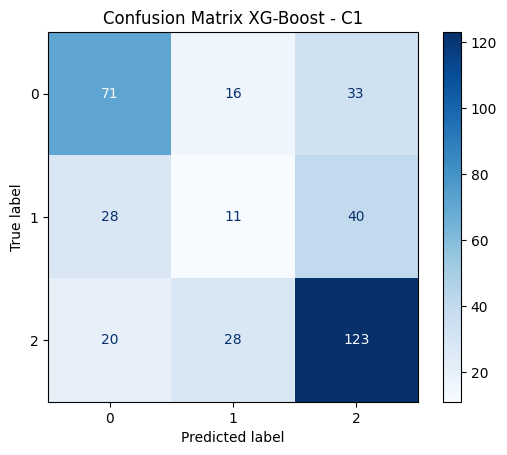


Running XGBoost for trainmet_odds_zonder_balancing


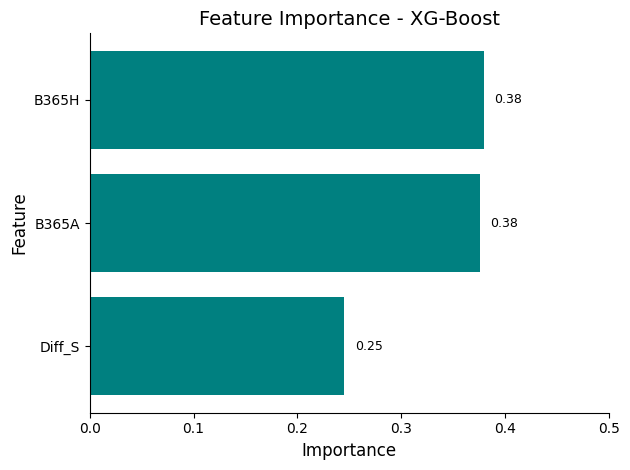

Results for trainmet_odds_zonder_balancing:
Accuracy: 0.5891891891891892
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       120
           1       0.00      0.00      0.00        79
           2       0.63      0.78      0.70       171

    accuracy                           0.59       370
   macro avg       0.39      0.50      0.44       370
weighted avg       0.46      0.59      0.52       370



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


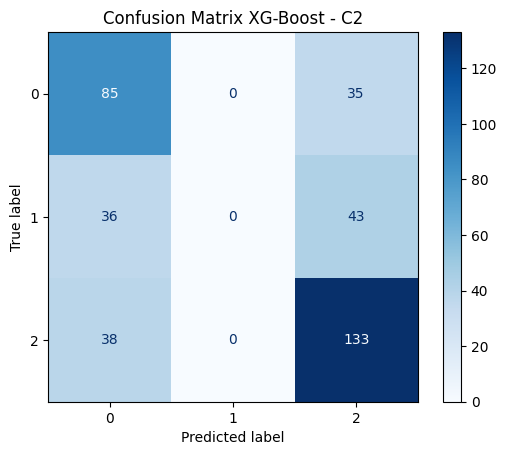


Running XGBoost for trainzonder_odds_met_balancing


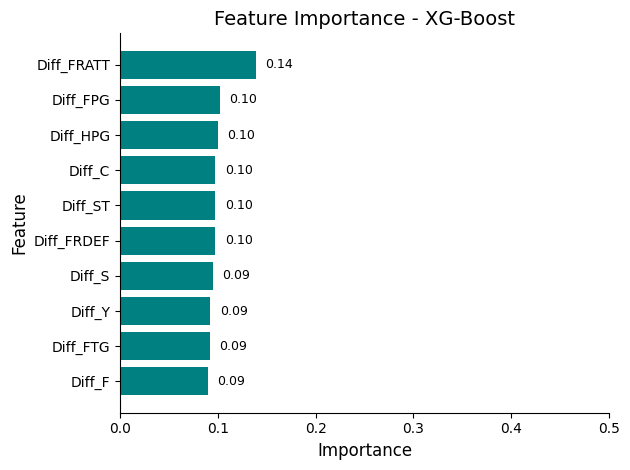

Results for trainzonder_odds_met_balancing:
Accuracy: 0.5459459459459459
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       120
           1       0.29      0.29      0.29        79
           2       0.64      0.65      0.64       171

    accuracy                           0.55       370
   macro avg       0.50      0.50      0.50       370
weighted avg       0.55      0.55      0.55       370



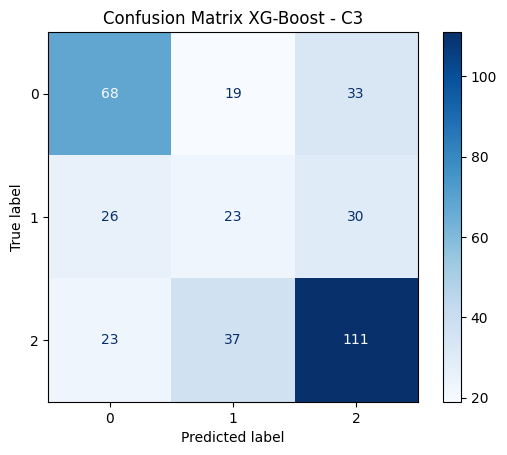


Running XGBoost for trainzonder_odds_zonder_balancing


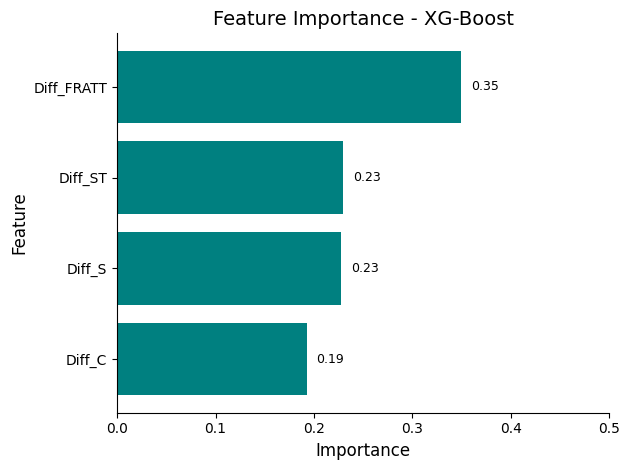

Results for trainzonder_odds_zonder_balancing:
Accuracy: 0.5756756756756757
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       120
           1       0.00      0.00      0.00        79
           2       0.59      0.83      0.69       171

    accuracy                           0.58       370
   macro avg       0.38      0.47      0.42       370
weighted avg       0.45      0.58      0.50       370



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


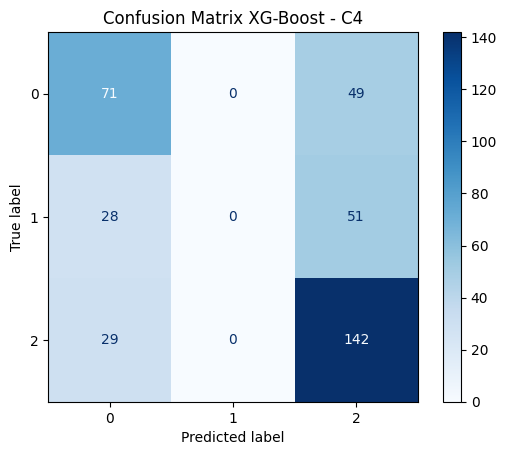

In [20]:
variant_name_mapping = {
    'trainmet_odds_met_balancing': 'C1',
    'trainmet_odds_zonder_balancing': 'C2',
    'trainzonder_odds_met_balancing': 'C3',
    'trainzonder_odds_zonder_balancing': 'C4'
}

feature_names_dict = {
    'trainmet_odds_met_balancing': ['B365H', 'B365D', 'B365A', 'Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FPG', 'Diff_HPG'],
    'trainmet_odds_zonder_balancing': ['B365H', 'B365A', 'Diff_S'],
    'trainzonder_odds_met_balancing': ['Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FTG', 'Diff_FPG', 'Diff_HPG', 'Diff_FRDEF', 'Diff_FRATT'],
    'trainzonder_odds_zonder_balancing': ['Diff_S', 'Diff_ST', 'Diff_C', 'Diff_FRATT']
}

hyperparameters_dict = {
    'trainmet_odds_met_balancing': {
        'n_estimators': 129, 'learning_rate': 0.049876021595567685, 'max_depth': 10, 'subsample': 0.7849527378148702,
        'min_child_weight': 2, 'colsample_bytree': 0.6120216069637563
    },
    'trainmet_odds_zonder_balancing': {
        'n_estimators': 142, 'learning_rate': 0.014241138185489662, 'max_depth': 5, 'subsample': 0.6020914931801977,
        'min_child_weight': 7, 'colsample_bytree': 0.5505854790099324
    },
    'trainzonder_odds_met_balancing': {
        'n_estimators': 144, 'learning_rate': 0.018046202637800254, 'max_depth': 10, 'subsample': 0.7572792965555748,
        'min_child_weight': 1, 'colsample_bytree': 0.90717604919467
    },
    'trainzonder_odds_zonder_balancing': {
        'n_estimators': 176, 'learning_rate': 0.00516504117880041, 'max_depth': 6, 'subsample': 0.5260425851574494,
        'min_child_weight': 7, 'colsample_bytree': 0.6163624968902534
    }
}

def generate_feature_importance_plot(model, feature_names, variant_name):
    importances = model.feature_importances_
    
    indices = importances.argsort()[::1]
    
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], rotation=0, ha="right", fontsize=10)
    importance = plt.barh(range(len(indices)), importances[indices], align="center", color='teal')
    
    plt.xlim(0, 0.50)
    plt.xticks([i * 0.10 for i in range(6)], fontsize=10)  
    
    plt.grid(False)
    
    for i, value in enumerate(importances[indices]):
        plt.text(value + 0.01, i, f"{value:.2f}", va='center', fontsize=9, color='black')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.title(f"Feature Importance - XG-Boost", fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"XG-Boost_Feature_Importance_{variant_name}.png", bbox_inches='tight')
    plt.show()
    plt.close()

def train_and_generate_plots(X_train, y_train, X_test, y_test, variant_name):
    params = hyperparameters_dict[variant_name]
    
    model = XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    
    feature_names = feature_names_dict[variant_name]

    readable_name = variant_name_mapping.get(variant_name, variant_name)
    
    generate_feature_importance_plot(model, feature_names, variant_name)
    
    y_pred = model.predict(X_test)
    print(f"Results for {variant_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix XG-Boost - {readable_name}")
    plt.savefig(f"XG confusion_matrix_{variant_name}.png", bbox_inches='tight')
    plt.show()
    plt.close()

for variant_name, (X_train, y_train) in datasets.items():
    if 'test' in variant_name:
        continue 
    
    print(f"\nRunning XGBoost for {variant_name}")
    
    if variant_name == 'trainmet_odds_met_balancing':
        X_test = datasets['testmet_odds_met_balancing'][0]
        y_test = datasets['testmet_odds_met_balancing'][1]
    elif variant_name == 'trainmet_odds_zonder_balancing':
        X_test = datasets['testmet_odds_zonder_balancing'][0]
        y_test = datasets['testmet_odds_zonder_balancing'][1]
    elif variant_name == 'trainzonder_odds_met_balancing':
        X_test = datasets['testzonder_odds_met_balancing'][0]
        y_test = datasets['testzonder_odds_met_balancing'][1]
    elif variant_name == 'trainzonder_odds_zonder_balancing':
        X_test = datasets['testzonder_odds_zonder_balancing'][0]
        y_test = datasets['testzonder_odds_zonder_balancing'][1]
    else:
        print(f"Unknown variant name {variant_name}, skipping.")
        continue

    X_train = X_train.values
    y_train = y_train.values
    X_test = X_test.values
    y_test = y_test.values
    
    train_and_generate_plots(X_train, y_train, X_test, y_test, variant_name)



Running TabNet on dataset variant: trainmet_odds_met_balancing

Early stopping occurred at epoch 12 with best_epoch = 5 and best_val_0_accuracy = 0.54595


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


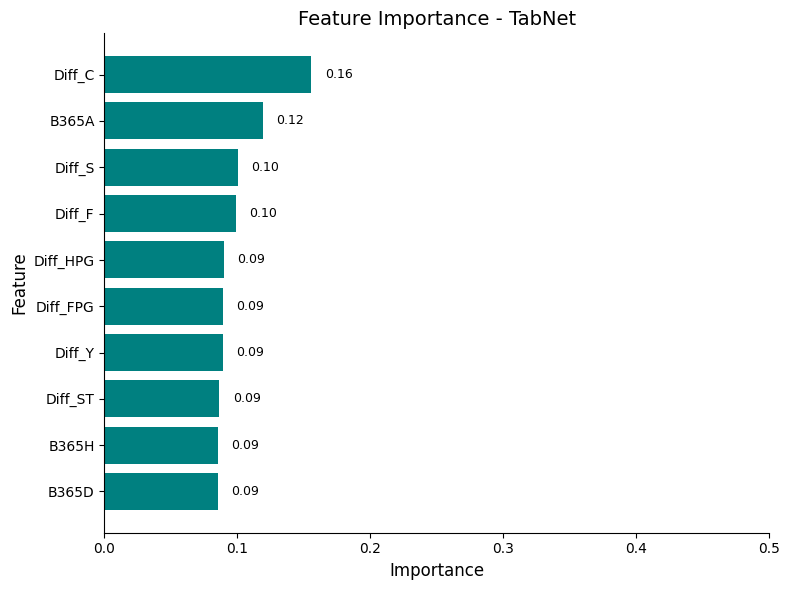

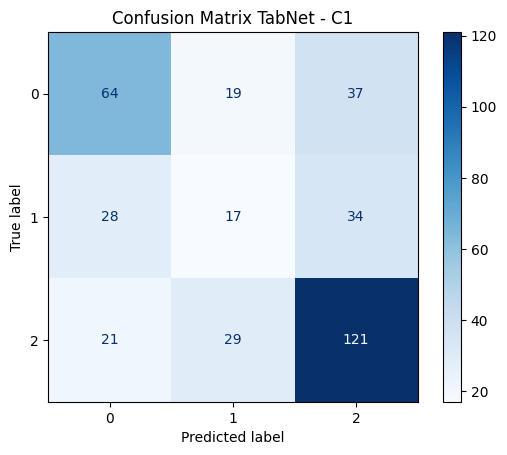

Confusion Matrix for trainmet_odds_met_balancing:
[[ 64  19  37]
 [ 28  17  34]
 [ 21  29 121]]

Running TabNet on dataset variant: trainmet_odds_zonder_balancing

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_accuracy = 0.61622


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


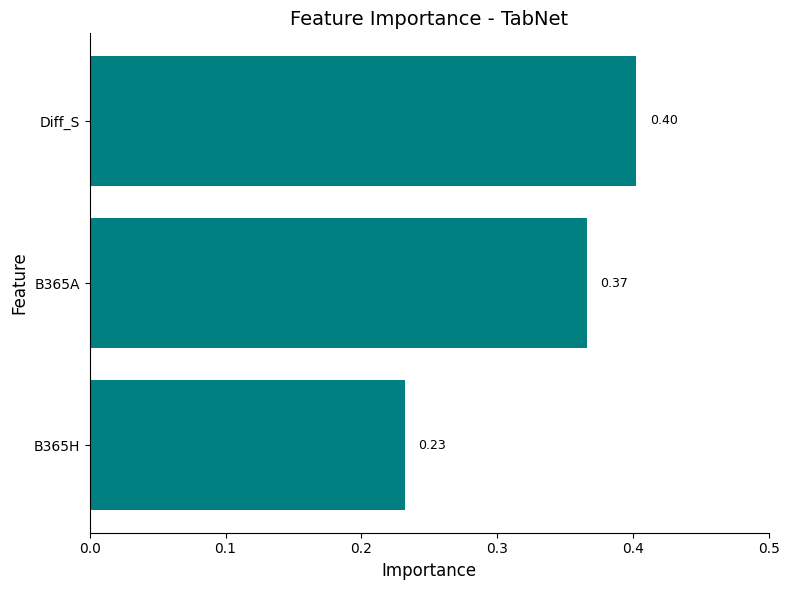

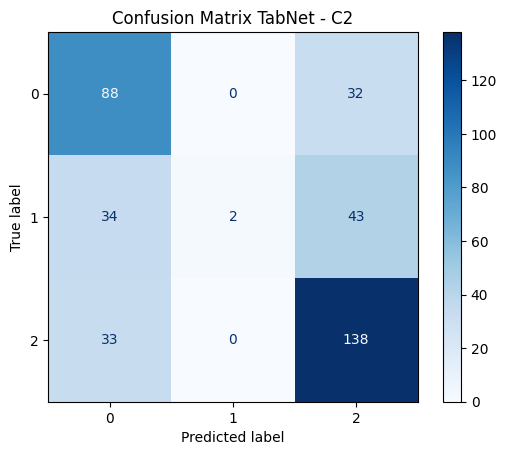

Confusion Matrix for trainmet_odds_zonder_balancing:
[[ 88   0  32]
 [ 34   2  43]
 [ 33   0 138]]

Running TabNet on dataset variant: trainzonder_odds_met_balancing

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_accuracy = 0.55405


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


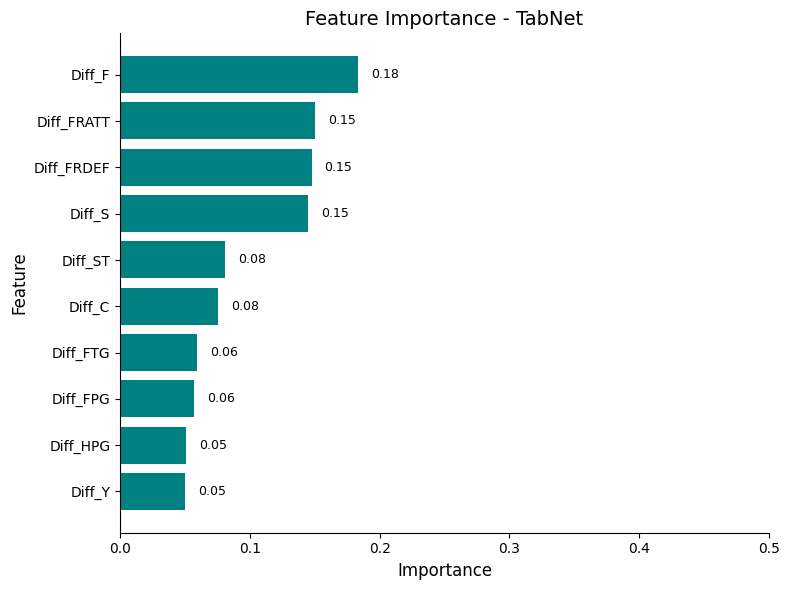

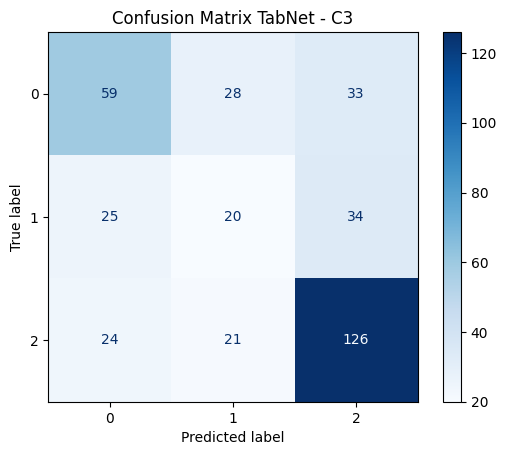

Confusion Matrix for trainzonder_odds_met_balancing:
[[ 59  28  33]
 [ 25  20  34]
 [ 24  21 126]]

Running TabNet on dataset variant: trainzonder_odds_zonder_balancing

Early stopping occurred at epoch 11 with best_epoch = 2 and best_val_0_accuracy = 0.58649


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


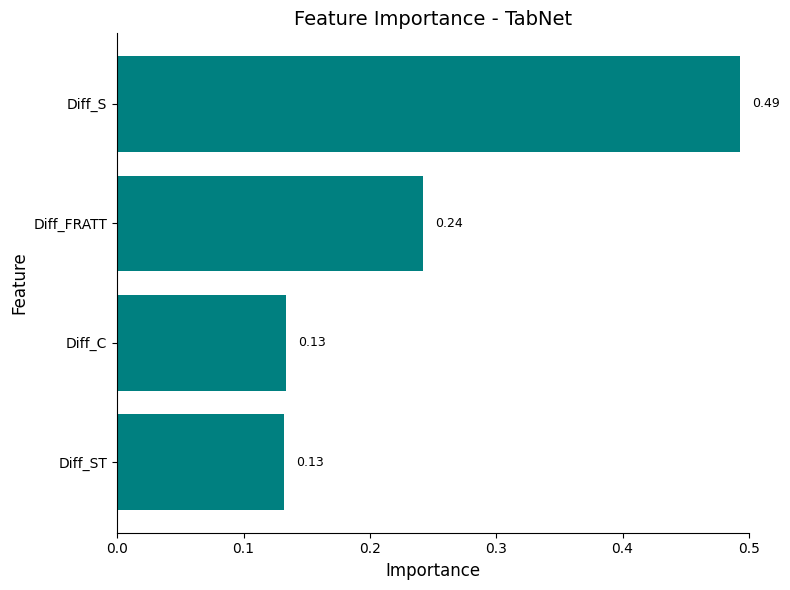

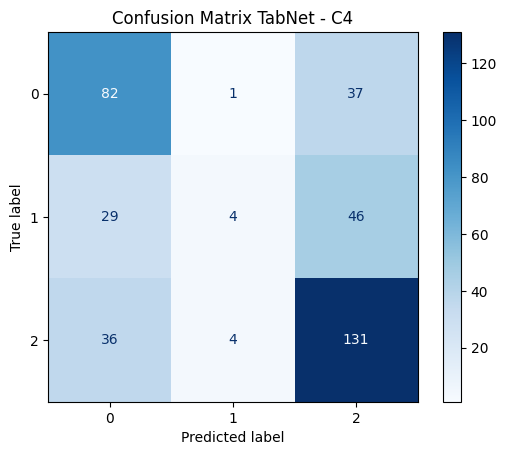

Confusion Matrix for trainzonder_odds_zonder_balancing:
[[ 82   1  37]
 [ 29   4  46]
 [ 36   4 131]]


In [21]:
SEED = 42  
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

variant_name_mapping = {
    'trainmet_odds_met_balancing': 'C1',
    'trainmet_odds_zonder_balancing': 'C2',
    'trainzonder_odds_met_balancing': 'C3',
    'trainzonder_odds_zonder_balancing': 'C4'
}

feature_names_dict = {
    'trainmet_odds_met_balancing': ['B365H', 'B365D', 'B365A', 'Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FPG', 'Diff_HPG'],
    'trainmet_odds_zonder_balancing': ['B365H', 'B365A', 'Diff_S'],
    'trainzonder_odds_met_balancing': ['Diff_S', 'Diff_ST', 'Diff_F', 'Diff_C', 'Diff_Y', 'Diff_FTG', 'Diff_FPG', 'Diff_HPG', 'Diff_FRDEF', 'Diff_FRATT'],
    'trainzonder_odds_zonder_balancing': ['Diff_S', 'Diff_ST', 'Diff_C', 'Diff_FRATT']
}

tabnet_hyperparameters = {
    'trainmet_odds_met_balancing': {
        'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 8, 'gamma': 0.02, 'n_shared': 2, 'lambda_sparse': 7.891392918016076e-05, 'patienceScheduler': 9, 'max_epochs': 50, 'patience': 7
    },
    'trainmet_odds_zonder_balancing': {
        'mask_type': 'entmax', 'n_da': 16, 'n_steps': 5, 'gamma': 0.1, 'n_shared': 3,
        'lambda_sparse': 0.00035632918778922634, 'patienceScheduler': 8, 'max_epochs': 29, 'patience': 5
    },
    'trainzonder_odds_met_balancing': {
        'mask_type': 'sparsemax', 'n_da': 24, 'n_steps': 8, 'gamma': 0.01, 'n_shared': 1,
        'lambda_sparse': 5.097139359389593e-05, 'patienceScheduler': 10, 'max_epochs': 50, 'patience': 10
    },
    'trainzonder_odds_zonder_balancing': {
        'mask_type': 'sparsemax', 'n_da': 16, 'n_steps': 3, 'gamma': 0.060000000000000005, 'n_shared': 1, 'lambda_sparse': 0.0002059204000149221, 'patienceScheduler': 10, 'max_epochs': 16, 'patience': 9
    }
}

def load_and_evaluate_tabnet_confusion_matrix(X_train, y_train, X_test, y_test, variant_name):
    params = tabnet_hyperparameters[variant_name]
    
    tabnet_model = TabNetClassifier(
        n_d=params['n_da'],
        n_a=params['n_da'],
        n_steps=params['n_steps'],
        gamma=params['gamma'],
        lambda_sparse=params['lambda_sparse'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        mask_type=params['mask_type'],
        n_shared=params['n_shared'],
        scheduler_params=dict(
            patience=params['patienceScheduler'],
            min_lr=1e-5,
            factor=0.5,
        ),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        verbose=0,
        seed=SEED, 
    )

    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        max_epochs=params['max_epochs'],
        patience=params['patience'],
        batch_size=64
    )

    feature_names = feature_names_dict[variant_name]
    
    y_pred_tabnet = tabnet_model.predict(X_test)
    
    importances = tabnet_model.feature_importances_
    
    indices = importances.argsort()[::1]
    
    plt.figure(figsize=(8, 6))
    plt.xlim(0, 0.50)
    plt.xticks([i * 0.10 for i in range(6)], fontsize=10)  
    
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], rotation=0, ha="right", fontsize=10)
    for i, value in enumerate(importances[indices]):
        plt.text(value + 0.01, i, f"{value:.2f}", va='center', fontsize=9, color='black')
        
    importance = plt.barh(range(len(indices)), importances[indices], align="center", color='teal')
    
    plt.grid(False)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.title(f"Feature Importance - TabNet", fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"Tabnet_Feature_Importance_{variant_name}.png", bbox_inches='tight')
    plt.show()
    plt.close()

    readable_name = variant_name_mapping.get(variant_name, variant_name)

    cm = confusion_matrix(y_test, y_pred_tabnet)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix TabNet - {readable_name}")
    plt.savefig(f"Tabnet_ConfusionMatrix{variant_name}.png", bbox_inches='tight')
    plt.show()

    class_names = ["class_1", "class_2", "class_3"]
    print(f"Confusion Matrix for {variant_name}:")
    print(cm)

for variant_name, (X_train, y_train) in datasets.items():
    if 'test' in variant_name:
        continue

    print(f"\nRunning TabNet on dataset variant: {variant_name}")

    if variant_name == 'trainmet_odds_met_balancing':
        X_test = datasets['testmet_odds_met_balancing'][0]
        y_test = datasets['testmet_odds_met_balancing'][1]
    elif variant_name == 'trainmet_odds_zonder_balancing':
        X_test = datasets['testmet_odds_zonder_balancing'][0]
        y_test = datasets['testmet_odds_zonder_balancing'][1]
    elif variant_name == 'trainzonder_odds_met_balancing':
        X_test = datasets['testzonder_odds_met_balancing'][0]
        y_test = datasets['testzonder_odds_met_balancing'][1]
    elif variant_name == 'trainzonder_odds_zonder_balancing':
        X_test = datasets['testzonder_odds_zonder_balancing'][0]
        y_test = datasets['testzonder_odds_zonder_balancing'][1]
    else:
        print(f"Unknown variant name {variant_name}, skipping.")
        continue

    X_train = X_train.values
    y_train = y_train.values
    X_test = X_test.values
    y_test = y_test.values

    load_and_evaluate_tabnet_confusion_matrix(X_train, y_train, X_test, y_test, variant_name)

